```
Workspace for testing and improving code base.

Usage: 
    Cells under each major heading are independent of each other but may require the initial import statement. 

License:
    BSD 3-Clause License

    Copyright (c) 2022, James Gardner.
    All rights reserved except for those for the gwbench code which remain reserved
    by S. Borhanian; the gwbench code is included in this repository for convenience.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are met:

    1. Redistributions of source code must retain the above copyright notice, this
       list of conditions and the following disclaimer.

    2. Redistributions in binary form must reproduce the above copyright notice,
       this list of conditions and the following disclaimer in the documentation
       and/or other materials provided with the distribution.

    3. Neither the name of the copyright holder nor the names of its
       contributors may be used to endorse or promote products derived from
       this software without specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
    AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
    IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
    DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
    FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
    DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
    SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
    CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
    OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
    OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

James Gardner, April 2022 

want to analyse science case/s for CE only:

CE-N 40km with CE-S 40km or 20km

if done, then look at CE-S with one ET detector

verify techniques by replicating *Borhanian and Sathya 2022*

###  To-do list

August 2022

Focus: *Australia*. Paper comparing the various decades of science cases for Australian GWDs.

Work on Fridays after 12 for the forseeable future. Lilli can help write the paper once we have results.

TODO
- CE 20km PMO in Aus vs US, include ET appropriately, no longer interested in CE only
    - Also want to study NEMO case study. Don't have full NEMO curve but can start with NEMO-LF.
        - Have run A+_200Hz cut through BNS science case.
    - I cannot remember how long it took to run BS2022_SIX. Remember, each task does all networks simultaneously to create the uniform flag. For publishing results, want to run the research networks alongside the calibration networks. For now, we might get away with just running them separately. I am increasing the time limit from 5 to 7 days (the maximum in slurm.conf).
- Matching BS2022 measurement errors
    - Why are SNR and inclination good but distance poor?
    - gwbench 0.7 update. Compare results again.
    - Compare single injection to see where measurment errors diverge
    - Use Ssohrab's plotters to narrow down the error
- Try with Bilby so that the results can be compared between Fisher and Bayesian. These are unlikely to agree but it would be better to have a handle ourselves on it.
        - Could also compare to BayesStar which can do integrated SNR, sky area, and distance fast (but nothing else)
    - Modify calculate_unified_injections.py to be modular with whichever software converts raw astro injections to processed detector results
    - Clean up I/O structure. Have files in SC dirs and each simply named <TASK_ID>.h5 with the metadata checked against that saved in the .h5 file.
        - At least, just store network, sc, task id and assume the rest is constant


In [ ]:
# to-do: stop CE alone being ill-conditioned, seems to work for BBH numeric wf --> get latest patch from Borhanian
# to-do: fix BNS numerical waveform, current error "numpy.linalg.LinAlgError: Array must not contain infs or NaNs" with HLVKI+ --> see above (still dropping BNS numerical injections but no longer the same error - 20220421)

In [ ]:
# to-do: change sigmoid fits to global optimisation to avoid needing the initial guesses in B&S2022, this is not possible with scipy, need to write my own or source a global curve fitting (apparantly a non-trivial problem)

In [ ]:
# to-do: refactor two plotting functions
# to-do: tidy up refactoring, reduce total number of arguments with unpacking?

"""In fact, we see that the three generations (A+, Voyager, and NG) are qualitatively different
with respect to every metric used in this study."""

In [2]:
from constants import *

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

from typing import List, Set, Dict, Tuple, Optional, Union, Any
from numpy.typing import NDArray

import os
from tqdm import tqdm
import pandas as pd
from IPython.display import display
import gwbench
import astropy
import glob
import pickle
import corner

# suppress warnings
from warnings import filterwarnings

from networks import *
from useful_functions import *
from useful_plotting_functions import *
from network_subclass import NetworkExtended
from results_class import InjectionResults
from filesystem_interaction import *

# from calculate_injections import *
from merger_and_detection_rates import *
from cosmological_redshift_resampler import *
from plot_collated_detection_rate import *
from plot_collated_PDFs_and_CDFs import *
from summary_table import *

plt.rcParams.update({"font.size": 14})
filterwarnings("ignore")

Autosaving every 60 seconds


ModuleNotFoundError: No module named 'corner'

### Replicating Borhanian and Sathya 2022 injections and detection rates, then for CE only 

In [ ]:
# batch detection rate results for given science case and network set

# waveform, LAL list: https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_sim_inspiral__h.html
# --- BNS ---
# science_case = 'BNS'
# wf_model_name, wf_other_var_dic = 'lal_bns', dict(approximant='IMRPhenomD_NRTidalv2') # for tidal, see https://arxiv.org/abs/1905.06011
# to-do: missing dimensionless tidal parameters, calculate tidal parameters from sampled m1, m2 in injections.py? requires Love number and radii (i.e. choose an EoS)
# --- BBH ---
science_case = "BBH"
wf_model_name, wf_other_var_dic = "lal_bbh", dict(approximant="IMRPhenomHM")
# --- analytic waveforms ---
# wf_model_name, wf_other_var_dic = 'tf2', None # to-do: stop using this once tidal params found
# wf_model_name, wf_other_var_dic = 'tf2_tidal', None

# number of injections per redshift bin (6 bins)
num_injs = 10

network_spec_list = BS2022_SIX["nets"]
# network_spec_list = CE_ONLY['nets']
# network_spec_list = CE_S_W_ET["nets"]

for network_spec in tqdm(network_spec_list):
    detection_rate_for_network_and_waveform(
        network_spec,
        science_case,
        wf_model_name,
        wf_other_var_dic,
        num_injs,
        show_fig=False,
        print_progress=False,
        print_reach=False,
    )

In [ ]:
# meta-batch to save all the required results (but not generate plots to save time) for the below cell
network_spec_list = [
    NET_DICT_LIST[0]["nets"][5],
]  # NET_LIST

science_cases = ("BNS", "BBH")
# --- numerical BNS as in B&S2021 ---
# wf_specifications = (('lal_bns', dict(approximant='IMRPhenomD_NRTidalv2')), ('lal_bbh', dict(approximant='IMRPhenomHM')))
# --- analytic BNS ---
wf_specifications = (("tf2_tidal", None), ("lal_bbh", dict(approximant="IMRPhenomHM")))

# number of injections per redshift bin (6 bins), tuple over science cases (more for symbolic wf.'s than numerical)
num_injs_list = (60000, 60000)

for network_spec in tqdm(network_spec_list):
    for j, science_case in enumerate(science_cases):
        wf_model_name, wf_other_var_dic = wf_specifications[j]
        detection_rate_for_network_and_waveform(
            network_spec,
            science_case,
            wf_model_name,
            wf_other_var_dic,
            num_injs_list[j],
            generate_fig=True,
            show_fig=False,
            print_progress=False,
            print_reach=False,
        )

In [ ]:
# debugging m1 <= 0 error

# run benchmarking on a single, manually set injection that caused the error
network_spec = ["A+_H", "A+_L", "V+_V", "K+_K", "A+_I"]
science_case, wf_model_name, wf_other_var_dic = (
    "BBH",
    "lal_bbh",
    dict(approximant="IMRPhenomHM"),
)
num_injs = 1  # arb, will override
file_name = "test.npy"
data_path = "/fred/oz209/jgardner/CEonlyPony/source/data_processed_injections/"

detection_rate_for_network_and_waveform(
    network_spec,
    science_case,
    wf_model_name,
    wf_other_var_dic,
    num_injs,
    generate_fig=False,
    show_fig=False,
    print_progress=False,
    print_reach=False,
    data_path=data_path,
    file_name=file_name,
    parallel=False,
    use_BS2022_seeds=False,
    log_uniformly_sampled_redshift=False,
    debug=False,
)

# hfp, hfc created before errors, therefore problem with net.calc_wf_polarizations_derivs_num?
#         self.del_hfpc = drd.calc_det_responses_derivs_num(None,self.wf,wf_deriv_symbs_string,self.f,self.inj_params,self.use_rot,'hf',step,method,order,n)
# eventually: gwbench wf_derivatives_num.part_deriv_ndGradient
# numerical gradient iterates and errors when m1=m2=nan when eta = 0.25000000071132467 occurs, is eta changing to get the gradient along eta evaluated at eta_0?
# eta is maximised at 0.25 when m1 = m2, since eta = 0.25 + epsilon, epsilon > 0, m1 and m2 error out
# the problem: there is no safeguard in wf_derivatives_num.part_deriv_ndGradient against eta close to 0.25, need to manually check step size (1e-9 too large)!
# eta can be close to 0.25 because m2 is sampled in [5 Msun, m1]

### Collating different networks saved using the above method

In [ ]:
# batch of six collated plots: all three network sets and two science cases
# assumes results saved: above results generating cell must be run to save results for this cell

# ! remember to update plot label for each case else the plot will be overwritten
# how standard the "standard 6" are is unclear, seems like an invention of B&S2022
# CE only, with 2G+ as a reference
# CE South with one ET detector

# adding HLVKI+ reference to CE nets
network_dict_list = [
    NET_DICT_LIST[0],
]
network_sets = [net_dict["nets"] for net_dict in network_dict_list]
# (BS2022_STANDARD_6['nets'],)
#                 CE_ONLY_C_and_S['nets'] + [['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']],
#                 CE_ONLY_C_and_N['nets'] + [['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']],
#                 CE_S_W_ET['nets'] + [['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']])
network_labels = [net_dict["label"] for net_dict in network_dict_list]
# ('standard_6', 'CE_only_C..S', 'CE_only_C..N', 'ET..CE_S')
science_cases = ("BNS", "BBH")

for i, network_set in enumerate(network_sets):
    for j, science_case in enumerate(science_cases):
        if science_case == "BNS":
            # wf_model_name, wf_other_var_dic = 'lal_bns', dict(approximant='IMRPhenomD_NRTidalv2')
            wf_model_name, wf_other_var_dic = (
                "tf2_tidal",
                None,
            )  # to-do: change to more accurate numerical once gwbench patch released
        elif science_case == "BBH":
            wf_model_name, wf_other_var_dic = "lal_bbh", dict(approximant="IMRPhenomHM")
        else:
            raise ValueError("Science case not recognised.")

        if wf_other_var_dic is not None:
            plot_label = f'NET_{network_labels[i]}_SCI-CASE_{science_case}_WF_{wf_model_name}_{wf_other_var_dic["approximant"]}'
        else:
            plot_label = (
                f"NET_{network_labels[i]}_SCI-CASE_{science_case}_WF_{wf_model_name}"
            )
        compare_detection_rate_of_networks_from_saved_results(
            network_set,
            science_case,
            plot_label=plot_label,
            show_fig=False,
            data_path="data_processed_injections/",
            parallel=True,
        )

### Measurement errors

In [ ]:
# B&S2022 plots cumulative density functions (CDF) versus redshift to show distribution of measurement errors (why not just use PDF, i.e. normalised histograms, like B2021?)
# for non-SNR quantities only use results above an SNR threshold (e.g. 10), alternatively, for all non--sky area quantities only use results below a 90% credible sky area threshold (e.g. 4.4e-2 sqrDeg, where the full Moon is ~20.0e-2 sqrDeg given a radius of 0.5 deg) --> don't have enough resolution to attempt sky-area thresholding

# batching collation of standard sets assuming results saved
# compare plots to B&S2022 Figs 3 and 4
network_dict_list = [
    NET_DICT_LIST[0],
]
network_sets = [net_dict["nets"] for net_dict in network_dict_list]
network_labels = [net_dict["label"] for net_dict in network_dict_list]
# network_sets = (BS2022_STANDARD_6['nets'],
#                 CE_ONLY_C_and_S['nets'] + [['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']],
#                 CE_ONLY_C_and_N['nets'] + [['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']],
#                 CE_S_W_ET['nets'] + [['A+_H', 'A+_L', 'V+_V', 'K+_K', 'A+_I']])
# network_labels = ('standard_6', 'CE_only_C..S', 'CE_only_C..N', 'ET_E..CE_S')
science_cases = ("BNS", "BBH")
specific_wfs = ("tf2_tidal", None)

for i, network_set in enumerate(tqdm(network_sets)):
    for j, science_case in enumerate(science_cases):
        plot_label = f"SCI-CASE_{science_case}_NETS_{network_labels[i]}"
        plot_title = f"Science case: {science_case}, network set: {network_labels[i]}"
        specific_wf = specific_wfs[j]
        if specific_wf is not None:
            plot_label += f"_WF_{specific_wf}"
            plot_title += f", WF: {specific_wf}"
        collate_measurement_errs_CDFs_of_networks(
            network_set,
            science_case,
            specific_wf=specific_wf,
            plot_label=plot_label,
            plot_title=plot_title,
            full_legend=False,
            print_progress=False,
            show_fig=False,
            normalise_count=True,
            xlim_list=None,
            threshold_by_SNR=True,
            CDFmin=1e-4,
            data_path="data_processed_injections/",
        )
#         # for reference, without SNR thresholding
#         collate_measurement_errs_CDFs_of_networks(network_set, science_case, specific_wf=specific_wf, plot_label=plot_label+'_SNR-THR_False', plot_title=plot_title, full_legend=False, print_progress=False, show_fig=False, normalise_count=True, xlim_list=None, threshold_by_SNR=False)

In [ ]:
# for direct comparison, use B&S2022's xlim_list
# --- options ---
options = (
    (BS2022_SIX, "BBH", "lal_bbh_IMRPhenomHM"),
    (BS2022_SIX, "BNS", "tf2_tidal"),
)
ymin_CDF = 1e-4

for net_dict, science_case, wf_model_name in options:
    network_set, network_label = net_dict["nets"], net_dict["label"]
    plot_label = f"NET_{network_label}_SCI-CASE_{science_case}_WF_{wf_model_name}"
    # plot_label = 'contoured'
    plot_title = f"Networks: {network_label}, science-case: {science_case}, waveform: {wf_model_name}"
    data_path = "data_processed_injections/"  #'old_data_processed_injections/'
    linestyles_from_BS2022 = True

    collate_measurement_errs_CDFs_of_networks(
        network_set,
        science_case,
        plot_label=plot_label + "_XLIMS_preset",
        plot_title=plot_title + ", XLIMS: preset to B&S2022",
        full_legend=False,
        print_progress=False,
        show_fig=False,
        normalise_count=True,
        xlim_list="B&S2022",
        threshold_by_SNR=True,
        CDFmin=ymin_CDF,
        data_path=data_path,
        num_bins=40,
        linestyles_from_BS2022=linestyles_from_BS2022,
        contour=False,
        parallel=True,
        debug=True,
        norm_tag="GWTC2",
        seed=12345,
    )

# recreating Figs 11--12
for net_dict, science_case, wf_model_name in options:
    network_set, network_label = net_dict["nets"], net_dict["label"]
    plot_label = f"NET_{network_label}_SCI-CASE_{science_case}_WF_{wf_model_name}"
    # plot_label = 'contoured'
    plot_title = f"Networks: {network_label}, science-case: {science_case}, waveform: {wf_model_name}"
    ymin_CDF = 1e-4
    data_path = "data_processed_injections/"  #'old_data_processed_injections/'
    linestyles_from_BS2022 = True

    collate_measurement_errs_CDFs_of_networks(
        network_set,
        science_case,
        plot_label=plot_label + "_XLIMS_preset_log-count",
        plot_title=plot_title + ", XLIMS: preset to B&S2022",
        full_legend=False,
        print_progress=False,
        show_fig=False,
        normalise_count=False,
        xlim_list="B&S2022-Figs11--12",
        threshold_by_SNR=True,
        CDFmin=ymin_CDF,
        data_path=data_path,
        num_bins=40,
        linestyles_from_BS2022=linestyles_from_BS2022,
        contour=False,
        parallel=True,
        debug=True,
        norm_tag="GWTC2",
        seed=12345,
    )

### Sky localisation
Is there a better way to analyse and/or communicate sky localisation?

In [ ]:
# --- input parameters ---
data_path = "tmp_data/data_processed_injections/"
input_file_name = "results_NET_CE-40-CBO_C..CE-20-PMO_N..CE-40-CBO_S_SCI-CASE_BNS_WF_tf2_tidal_INJS-PER-ZBIN_30000.npy"
plot_title = file_name_to_multiline_readable(input_file_name)
# file_name = 'results_NET_A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BNS_WF_tf2_tidal_INJS-PER-ZBIN_30000.npy'
output_path = "plots/"
output_file_name = "sky_localisation.pdf"

# loading
results = np.load(data_path + input_file_name)

z = results[:, 0]
snr = results[:, 1]
skyarea = results[:, 6]

# plotting
good_colour = "#e84393"
v_good_colour = "#00b894"

plt.rcParams.update({"font.size": 14})
fig, axs = plt.subplots(
    2, 1, sharex=True, figsize=(8, 12), gridspec_kw=dict(hspace=0.05)
)

axs[0].axhspan(SNR_THRESHOLD_HI, max(snr), color=v_good_colour, alpha=0.5)
axs[0].axhspan(
    SNR_THRESHOLD_LO, SNR_THRESHOLD_HI, color=good_colour, linestyle="-", alpha=0.5
)
axs[0].loglog(z, snr, ",")
axs[0].set(ylabel=r"SNR, $\rho$", ylim=(None, max(snr)))

if max(skyarea) > TOTAL_SKY_AREA_SQR_DEG:
    axs[1].axhspan(TOTAL_SKY_AREA_SQR_DEG, max(skyarea), color=(0, 0, 0, 0.5))
axs[1].loglog(
    z[snr < SNR_THRESHOLD_LO], skyarea[snr < SNR_THRESHOLD_LO], ",", color="#0984e3"
)
axs[1].loglog(
    z[np.logical_and(SNR_THRESHOLD_LO < snr, snr < SNR_THRESHOLD_HI)],
    skyarea[np.logical_and(SNR_THRESHOLD_LO < snr, snr < SNR_THRESHOLD_HI)],
    ",",
    color=good_colour,
)
axs[1].loglog(
    z[SNR_THRESHOLD_HI < snr], skyarea[SNR_THRESHOLD_HI < snr], ",", color=v_good_colour
)
axs[1].axhline(
    EM_FOLLOWUP_SKY_AREA_SQR_DEG, color="k", linewidth=1, label="follow-up\nthreshold"
)
axs[1].axhline(
    MOON_SKY_AREA_SQR_DEG, color="k", linestyle="--", linewidth=1, label="Moon"
)
axs[1].set(
    ylabel=r"$\Omega_{90}$ / deg${}^2$", xlabel="redshift, z", ylim=(None, max(skyarea))
)
axs[1].legend(handlelength=1)

fig.suptitle(plot_title, y=0.9, verticalalignment="baseline")
fig.align_labels()

fig.canvas.draw()
force_log_grid(axs[0])
force_log_grid(axs[1])

# fig.savefig(output_path + output_file_name, bbox_inches='tight')
# # .pdf is 5 MB uncompressed, save as a .jpg for messaging (.png has a transparent background)
# fig.savefig(output_path + output_file_name.replace('.pdf', '.jpg'), bbox_inches='tight')
plt.show()

Contour plot

In [ ]:
# to-do: detail contour plot to examine sky localisation, contours from 10, 30, and 100
# to-do: invent some quantitative metrics to judge sky localisation
results = InjectionResults(
    "results_NET_A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BBH_WF_lal_bbh_IMRPhenomHM_INJS-PER-ZBIN_250000.npy"
)
seed = 12345
resampled_results = resample_redshift_cosmologically_from_results(results, seed=seed)

plt.rcParams.update({"font.size": 14})
fig, axs = plt.subplots(
    2,
    6,
    figsize=(20, 3.75),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(wspace=0.05, hspace=0.05),
)
for ax in axs.flatten():
    ax.set(xscale="log", yscale="log")
# axs[0].loglog(results.redshift, results.snr, ',')
# axs[1].loglog(results.redshift, results.sky_area_90, ',')
# axs[0].loglog(resampled_results[:,0], resampled_results[:,1], ',')
# axs[1].loglog(resampled_results[:,0], resampled_results[:,6], ',')
add_measurement_errs_CDFs_to_axs(
    axs,
    resampled_results,
    40,
    "r",
    "-",
    "test",
    normalise_count=True,
    threshold_by_SNR=True,
    contour=True,
)
plt.show()
# what's happening at large z > 30? not quite a shelf but still somewhat shrimp-like

### Following B&S2022 Section 4A: *Incorporation of redshift-dependent merger rates*

In [ ]:
norm_tag = "GWTC2"
if norm_tag == "GWTC3":
    normalisations = (GWTC3_MERGER_RATE_DENSITY_BNS, GWTC3_MERGER_RATE_DENSITY_BBH)
elif norm_tag == "GWTC2":
    normalisations = (GWTC2_MERGER_RATE_DENSITY_BNS, GWTC2_MERGER_RATE_DENSITY_BBH)

# # to use on saved results or compare to B&S2022
zmin, zmax = 1e-2, 50
# to compare to Ssohrab's email
# zmin, zmax = 1.7e-3, 50

# first, check that can recover a 10-year observation merger population (see From_Ssohrab_BNS_population_vs_redshift.png)
xlim, ylim = (zmin, zmax), (5e-1, 8e5)
z_arr = np.geomspace(*xlim, 100)
bns_rate_arr = np.array(
    parallel_map(
        lambda z: merger_rate_bns(z, normalisation=normalisations[0]),
        z_arr,
        parallel=True,
    )
)
bbh_rate_arr = np.array(
    parallel_map(
        lambda z: merger_rate_bbh(z, normalisation=normalisations[1]),
        z_arr,
        parallel=True,
    )
)
bns_obs_rate_arr = np.array(
    parallel_map(
        lambda z: merger_rate_in_obs_frame(
            merger_rate_bns, z, normalisation=normalisations[0]
        ),
        z_arr,
        parallel=True,
    )
)
bbh_obs_rate_arr = np.array(
    parallel_map(
        lambda z: merger_rate_in_obs_frame(
            merger_rate_bbh, z, normalisation=normalisations[1]
        ),
        z_arr,
        parallel=True,
    )
)
# merger rate R(z) in (count)/yr, multiply by number of years to get (count)
observation_time_in_years = 10

The units of $R(z)$ are $\frac{[\text{count}]}{\text{year}\, [\text{redshift}]}$ since the yearly number of sources in $(z_0,z_0+\Delta z)$ is $\int_{z_0}^{z_0+\Delta z} R(z) \text{d}z$ not $R_i=R(z^\ast)$ where $z^\ast$ is any point in, e.g. the geometric mean of, $(z_0,z_0+\Delta z)$.

Instead of $p_i = \frac{R_i}{\sum_j R_j}$, therefore, I use $q_i = \frac{R_i \Delta z_i}{\sum_j R_j \Delta z_j} \approx \frac{R_i \Delta z_i}{\int R(z) \text{d}z}$ where $\Delta z_i$ is the width of the bin as the probability of selecting the index $i$ of each bin. For a ten-year observation period $\tau=10$, I draw $\tau \int R(z) \text{d}z$ samples from the probability distribution which means that the expected number of samples in each bin is $\frac{\tau R_i \Delta z_i \int R(z) \text{d}z}{\sum_j R_j \Delta z_j}\approx \tau R_i \Delta z_i\approx \tau\int_{z_0}^{z_0+\Delta z} R(z) \text{d}z$ as it should be (instead of $\frac{\tau R_i \int R(z) \text{d}z}{\sum_j R_j}$).

Plotting $\tau R_i \Delta z_i$ against $z$ is *not* the same as plotting $\tau R(z)$ against $z$ since, as the width of each bin decreases, $\tau R_i \Delta z_i \rightarrow 0$. For example, for a uniform merger rate, splitting a bin in half means that there are now two bins next to each other with half the initial number of sources. On a plot, however, it just appears that the number of sources decreased since the split bins look the same.

In [ ]:
# replicating section 4A
# N in B&S2022, containing ~2000 injections from uniform sampler (varying due to randomness and linear sampling)
num_subzbin = 150  # 150 in B&S2022 but 75 in Ssohrab's email.
subzbin = list(
    zip(
        np.geomspace(zmin, zmax, num_subzbin + 1)[:-1],
        np.geomspace(zmin, zmax, num_subzbin + 1)[1:],
    )
)
# using geometric mean to find the log-centre of each bin
subzbin_centres = [gmean(zbin) for zbin in subzbin]
subzbin_widths = np.array([zbin[1] - zbin[0] for zbin in subzbin])
# using rate in the source frame like B&S2022, to-do: does this make sense if we're coutning observations? are we trying to emulate using a cosmological sampler originally?

merger_rate_fns = (
    lambda z: merger_rate_bns(z, normalisation=normalisations[0]),
    lambda z: merger_rate_in_obs_frame(
        merger_rate_bns, z, normalisation=normalisations[0]
    ),
    lambda z: merger_rate_bbh(z, normalisation=normalisations[1]),
    lambda z: merger_rate_in_obs_frame(
        merger_rate_bbh, z, normalisation=normalisations[1]
    ),
)
# R_i in B&S2022
subzbin_merger_rates = [
    np.array(parallel_map(merger_rate, subzbin_centres, parallel=True))
    for merger_rate in merger_rate_fns
]
# p_i in B&S2022
subzbin_probabilities = [rate / rate.sum() for rate in subzbin_merger_rates]
# q_i, weighting by width of each bin to estimate the actual number of mergers (see latex'd notes)
# TODO: check whether this makes a difference
subzbin_weighted_probs = [
    rate * subzbin_widths / np.sum(rate * subzbin_widths)
    for rate in subzbin_merger_rates
]

# "the desired [total, cosmological] number" of mergers over 10 years, integrating the merger rate in the *source* frame over the redshift range
observation_time_in_years = 10
num_draws = [
    int(observation_time_in_years * quad(merger_rate, zmin, zmax)[0])
    for merger_rate in merger_rate_fns
]
drawn_indicies = [
    rv_discrete(values=(range(num_subzbin), pdf)).rvs(size=num_draws[i])
    for (i, pdf) in enumerate(subzbin_probabilities)
]
drawn_weighted_inds = [
    rv_discrete(values=(range(num_subzbin), pdf)).rvs(size=num_draws[i])
    for (i, pdf) in enumerate(subzbin_weighted_probs)
]
# n_i in B&S2022: sample i with probability p_i "up to the desired [total, cosmological] number" of mergers over 10 years
subzbin_num_samples = [
    np.array([np.sum(indicies == i) for i in range(num_subzbin)])
    for indicies in drawn_indicies
]
subzbin_num_samples_weighted = [
    np.array([np.sum(indicies == i) for i in range(num_subzbin)])
    for indicies in drawn_weighted_inds
]

# cumulative merger rate (goes from zero but this should change little), pass source frame to detection_rate_limit
# ! (Lilli's question Dec 5 '22) -> detection_rate_limit does not adjust for the 10 year observation period as is done above. Need to include an additional factor (just look at the histogram)
# normalisation taken care of above
# TODO: compare the cumulative curve to BS's
cumulative_merger_rate_bns_obs = np.array(
    parallel_map(
        lambda z: observation_time_in_years
        * detection_rate_limit(merger_rate_fns[0], z),
        subzbin_centres,
        parallel=True,
    )
)
cumulative_merger_rate_bbh_obs = np.array(
    parallel_map(
        lambda z: observation_time_in_years
        * detection_rate_limit(merger_rate_fns[2], z),
        subzbin_centres,
        parallel=True,
    )
)

In [ ]:
colour1, colour2 = "r", "b"

plt.rcParams.update({"font.size": 14})
fig, axs = plt.subplots(
    2, 1, sharex=True, figsize=(7.8, 12), gridspec_kw=dict(hspace=0.1)
)

axs[0].loglog(
    z_arr,
    observation_time_in_years * bns_rate_arr,
    color=colour1,
    label="BNS source frame",
)
axs[0].loglog(
    z_arr,
    observation_time_in_years * bns_obs_rate_arr,
    linestyle="--",
    color=colour1,
    label="BNS observer frame",
)
axs[0].loglog(
    z_arr,
    observation_time_in_years * bbh_rate_arr,
    color=colour2,
    label="BBH source frame",
)
axs[0].loglog(
    z_arr,
    observation_time_in_years * bbh_obs_rate_arr,
    linestyle="--",
    color=colour2,
    label="BBH observer frame",
)
axs[0].set(ylabel=r"10-year count per redshift, $10\, R(z)$", xlim=xlim, ylim=ylim)
axs[0].set_ylabel("10-year count per redshift,\n" + r"$10\, R(z)$", fontsize=20)
axs[0].legend()
axs[0].set_title(f"{norm_tag}–normalised merger population per redshift")
force_log_grid(axs[0])

# where='mid' makes steps occur half (presumably arithmetic average) way between x values
axs[1].step(
    subzbin_centres,
    subzbin_num_samples_weighted[0],
    color=colour1,
    where="mid",
    linewidth=1,
    label="BNS source frame",
)
axs[1].step(
    subzbin_centres,
    subzbin_num_samples_weighted[1],
    color=colour1,
    linestyle="--",
    where="mid",
    linewidth=0.5,
    label="BNS observer frame",
)
axs[1].step(
    subzbin_centres,
    subzbin_num_samples_weighted[2],
    color=colour2,
    where="mid",
    linewidth=1,
    label="BBH source frame",
)
axs[1].step(
    subzbin_centres,
    subzbin_num_samples_weighted[3],
    color=colour2,
    linestyle="--",
    where="mid",
    linewidth=0.5,
    label="BBH observer frame",
)
axs[1].loglog(
    subzbin_centres,
    cumulative_merger_rate_bns_obs,
    color="k",
    linewidth=2,
    label="cumulative BNS obs.",
)
axs[1].loglog(
    subzbin_centres,
    cumulative_merger_rate_bbh_obs,
    color="k",
    linestyle="--",
    linewidth=2,
    label="cumulative BBH obs.",
)
axs[1].axvline(
    EM_FOLLOWUP_REDSHIFT_HI,
    color="g",
    linestyle="-.",
    label=f"{EM_FOLLOWUP_LUMINOSITY_DISTANCE_MPC_HI:.0f} Mpc",
)
axs[1].set(xscale="log", yscale="log")
# axs[1].loglog(subzbin_centres, subzbin_num_samples[0], '.', color='r')
axs[1].set(xlabel="redshift, $z$", xlim=xlim, ylim=ylim)
# colour is red to signify that this is a problematic axis that changes with the choice of bin width
axs[1].set_ylabel(
    "10-year count in bin,\n"
    + r"$\frac{R_i \Delta z_i}{\sum_k R_k \Delta z_k}10 \int R(z) \mathrm{d}z\approx10\,R_i \Delta z_i$",
    fontsize=20,
    color="r",
)
axs[1].legend()
axs[1].set_title(f"{norm_tag}–normalised merger population sampled")
force_log_grid(axs[1])
axs[1].set_yticks([10**i for i in range(6)], color="r")
axs[1].set_yticklabels([rf"$10^{i}$" for i in range(6)], color="r")
axs1_twin = axs[1].twinx()
axs1_twin.set_ylabel("10-year cumulative count", fontsize=20, color="k")
axs1_twin.set(xlim=xlim, ylim=ylim, yscale="log")

fig.align_labels()
fig.savefig(f"plots/ten-year_population_combined_{norm_tag}.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# sampling uniformly n_i times from the saved data in the subzbin with index i
file = "data_processed_injections/results_NET_A+_H..A+_L..K+_K..A+_I..ET_E_SCI-CASE_BNS_WF_tf2_tidal_INJS-PER-ZBIN_60000.npy"
colours = ("b", "r", "k")
big_zbins_end_points = (0.02, 0.5, 1, 2, 4, 10, 50)

results = np.load(file)
resampled_results = resample_redshift_cosmologically_from_results(
    results, "BNS"
)  # , print_progress=True, print_samples_with_replacement=True)

ax.rcParams.update({"font.size": 14})
fig, axs = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=(8, 8), gridspec_kw=dict(hspace=0.05)
)
axs[0].loglog(
    results[:, 0],
    results[:, 1],
    ",",
    color=colours[0],
    label=f"log-uniformly sampled results: {len(results)} points",
)
for endpoint in big_zbins_end_points:
    for ax in axs:
        ax.axvline(endpoint, color="k", linewidth=0.5)
axs[1].loglog(
    resampled_results[:, 0],
    resampled_results[:, 1],
    ",",
    color=colours[1],
    label=f"cosmo. re-sampled results: {len(resampled_results)} points",
)
axs1_twin = axs[1].twinx()
# using observed rate
axs1_twin.loglog(
    subzbin_centres,
    cumulative_merger_rate_bbh_obs,
    color=colours[2],
    linewidth=2,
    label="cumulative BNS observed",
)
axs1_twin.set_ylabel("10-year cumulative count", color=colours[2])
axs1_twin.set(xlim=xlim, ylim=ylim, yscale="log")

axs[0].set(ylabel="integrated SNR")
axs[0].set_title(
    f"re-sampling redshift cosmologically\n{file_name_to_multiline_readable(file)}"
)
axs[1].set(xlabel="redshift, z", xlim=(2e-2, 5e1))
axs[1].set_ylabel("integrated SNR", color=colours[1])
axs[1].yaxis.label.set_color(colours[1])
axs[1].tick_params(axis="y", which="both", colors=colours[1])

axs[0].legend(
    labels=axs[0].get_legend_handles_labels()[1],
    handles=[mlines.Line2D([], [], color=colours[0])],
    loc="lower right",
)
axs[1].legend(
    labels=(
        *axs[1].get_legend_handles_labels()[1],
        *axs1_twin.get_legend_handles_labels()[1],
    ),
    handles=[
        mlines.Line2D([], [], color=colours[1]),
        mlines.Line2D([], [], color=colours[2]),
    ],
    loc="lower right",
)

fig.align_labels()

for ax in axs:
    force_log_grid(ax)

fig.savefig(
    "plots/cosmological_resampling_from_log-uniform_BNS.png", bbox_inches="tight"
)
plt.show()

Lilli's question: why is the max in range count 132 / year when the BNS GWTC-2 merger rate suggests around O(10) / year?

#### Because: the GWTC-2 BNS value is a merger rate *density* and if the actual cumulative count per year is calculated by referencing the comoving volume and integrating against redshift then the value of O(100) / year is recovered and matches that produced by my cosmological resampling.

For posterity, here is my workflow at the time (the catch was that I had made a mistake previously with the 10 year cumulative count not scaling to 10 years, which meant that the accumlation mismatched the bin counts).

- - -

Indeed the old plot `ten-year_population_combined_GWTC2.pdf` in the cumulative BNS obs. curve divided by 10 does suggest O(10) / year at ~0.1 redshift which is 500 Mpc.

- remember that GWTC2 -> 500 Gpc^-3 year^-1 \[redshift^-1\] is the local (z=0) normalisation of the merger rate density (\dot{n} in BS2022) and needs to be multiplied by a co-moving volume and a redshift interval (i.e. integrated against redshift) to get a count  
    - Is O(100) / year even wrong once this is taken into account? Ignoring Lilli's concern, the cumulative count graph should still agree and that discrepancy does remain.
- Am using GWTC-2
- Summary table does adjust counts for 10 year observation time
- EM_FOLLOWUP_REDSHIFT_LO is also off by the same factor of 10, i.e. 3 is for 10 years not 1
- output data does have O(1000) in range meaning O(100) / year incorrectly
- resampling code looks the initally same as the code behind the above cumulative count graph
- cosmological resampling requests O(100) / year

TODO:
- figure out why cosmological resampling is wrong and old plot is right
- I used q_i (weighted by redshift width of sub-bin) as my PDF rather than p_i in BS2022, perhaps try with uniform rates even though R(z)dz is the actual count in a bin.


In [ ]:
# almost uniform in redshift
df_pre = pd.read_hdf(
    "reunification/extracted_data/30830111/data_processed_injections/NET_NEMO_AU..ET_E..CE-40-CBO_C_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
)
# resampled in redshift to GWTC2 rate
df_post = pd.read_hdf(
    "old_data/data_repo_30830111/NET_NEMO_AU..ET_E..CE-40-CBO_C_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
)
print(
    len(df_pre.loc[df_pre["redshift"] < EM_FOLLOWUP_REDSHIFT_HI]),
    len(df_post.loc[df_post["redshift"] < EM_FOLLOWUP_REDSHIFT_HI]),
)

In [ ]:
# using seed from run_as_task... .PY
seed = 12345
seed_sequence = np.random.SeedSequence(seed).spawn(2)
cosmological_seed = np.random.default_rng(seed_sequence[0])

subzbin, subzbin_num_samples = cosmological_redshift_sample(
    "BNS",
    norm_tag="GWTC2",
    debug=False,
    cosmological_seed=cosmological_seed,
    # a bit silly to multiply by 10 then divide by 10, but for completeness
    observation_time_in_years=10,
)

# divide by 10 to get per year
subzbin_num_samples_per_year = subzbin_num_samples / 10

# this is a upper bound on the count / year in range for all BNS GWTC2 results from this cosmological model
index_of_threshold = np.searchsorted(
    [zbin[1] for zbin in subzbin], EM_FOLLOWUP_REDSHIFT_HI
)
above_range_rhs_of_bin = subzbin[index_of_threshold][1]
in_range_upper_bound = np.sum(subzbin_num_samples_per_year[: index_of_threshold + 1])
print(
    f"Cosmological model for GWTC2-BNS requests {in_range_upper_bound:.2f} / year within z={EM_FOLLOWUP_REDSHIFT_HI:.3f} (D_L={EM_FOLLOWUP_LUMINOSITY_DISTANCE_MPC_HI} Mpc) and then lack of injections in sub-z-bins reduces to 132 / year."
)

# plot
plt.plot([zbin[1] for zbin in subzbin], subzbin_num_samples_per_year, ".")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("count / year in sub-z-bin")
plt.xlabel("z")
plt.axvline(EM_FOLLOWUP_REDSHIFT_HI, color="r")
plt.show()
plt.clf()


# deconstructing detection_rate_limit into component functions to plot and investigate
normalisation = GWTC2_MERGER_RATE_DENSITY_BNS
# \dot{n}(z) in BS2022
merger_rate_density = lambda z: injections.bns_md_merger_rate(z)
# converting merger rate density to Mpc^-3 to match comoving volume units
norm_merger_rate_density = (
    lambda z: 1e-9
    * merger_rate_density(z)
    * normalisation
    / injections.bns_md_merger_rate(0)
)
norm_merger_rate = lambda z: norm_merger_rate_density(z) * differential_comoving_volume(
    z
)
norm_merger_rate_obs_frame = lambda z: norm_merger_rate(z) / (1 + z)
cumulative_norm_merger_rate_obs_frame = lambda z: quad(
    norm_merger_rate_obs_frame,
    0,
    z,
)[0]

# looks like 132/year=O(100) / year without 10 year scaling. Was the old graph incorrect?
print(
    "deconstructed count / year",
    cumulative_norm_merger_rate_obs_frame(EM_FOLLOWUP_REDSHIFT_HI),
)

# gives the same result
print(
    "auto count / year",
    detection_rate_limit(
        merger_rate_bns,
        EM_FOLLOWUP_REDSHIFT_HI,
        normalisation=GWTC2_MERGER_RATE_DENSITY_BNS,
    ),
)

# overestimate of count in range from using RHS of sub-z-bin
print(
    "overestimated count / year",
    detection_rate_limit(
        merger_rate_bns,
        above_range_rhs_of_bin,
        normalisation=GWTC2_MERGER_RATE_DENSITY_BNS,
    ),
)
# TODO: figure out if it is just a coincidence that the actual number in range in the resample is close to the true value despite overestimation (i.e. that the loss due to empty sub bins equals the gain from using the RHS of the last sub bin)


# data
redshifts = np.geomspace(1e-2, 50, 100)

# using the deconstructed functions above
data1 = parallel_map(norm_merger_rate_density, redshifts)
data2 = parallel_map(differential_comoving_volume, redshifts)
data3 = parallel_map(norm_merger_rate_obs_frame, redshifts)
data4 = parallel_map(cumulative_norm_merger_rate_obs_frame, redshifts)


# plotting
plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(
    4, 1, figsize=(6, 12), sharex=True, gridspec_kw=dict(hspace=0.05)
)

axs[0].plot(redshifts, data1, label="data")
axs[0].axhline(
    1e-9 * GWTC2_MERGER_RATE_DENSITY_BNS,
    color="r",
    linestyle="dashed",
    label="GWTC-2 BNS value in\nMpc^-3 year^-1 (redshift^-1)",
)
# axs[0].set_yticks([1e-9, 1e-7])
# axs[0].set_ylim([1e-10, 5e-6])
# axs[0].set_yticklabels([rf"$10^{i}$" for i in [-9, -7]])

# axs0_twin = axs[0].twinx()
# twin_colour = "grey"
# axs0_twin.set_ylim([1e-10, 5e-6])
# axs0_twin.set_ylabel("[Gpc^-3 year^-1 redshift^-1]", color=twin_colour, rotation='horizontal', ha='left')
# axs0_twin.set_yscale('log')
# axs0_twin.set_yticks([1e-9, 1e-7])
# axs0_twin.set_yticklabels([rf"$10^{i}$" for i in [-9, -7]])
# axs0_twin.set(xlim=xlim, ylim=ylim, yscale="log")
# axs0_twin.set_yticks([10**i for i in range(6)], color=twin_colour)
# axs0_twin.set_yticklabels([rf"$10^{i}$" for i in range(6)], color=twin_colour)

axs[1].plot(redshifts, data2)
axs[2].plot(redshifts, data3)

axs[3].plot(redshifts, data4, label="data")
axs[3].axhline(132, color="m", linestyle="dashed", label="in range: ~132 / year")

axs[0].set_ylabel(
    "merger rate density,\n" + r"$\dot{n}(z)$" + " [Mpc^-3 year^-1 (redshift^-1)]",
    rotation="horizontal",
    ha="right",
)
axs[1].set_ylabel(
    "infinitesimal co-moving volume,\n"
    + r"$\frac{\mathrm{d}V}{\mathrm{d}z}(z)$"
    + " [Mpc^3]",
    rotation="horizontal",
    ha="right",
)
axs[2].set_ylabel(
    "merger rate in observer's frame,\n"
    + r"$R_{obs}(z)=\frac{\dot{n}\frac{\mathrm{d}V}{\mathrm{d}z}}{1+z}$"
    + " [year^-1 (redshift^-1)]",
    rotation="horizontal",
    ha="right",
)
axs[3].set_ylabel(
    "cumulative count in observer's frame,\n"
    + r"$\int_0^z R_{obs}(z') \mathrm{d}z'$"
    + " [year^-1]",
    rotation="horizontal",
    ha="right",
)
for ax in axs:
    ax.set_yscale("log")
    ax.grid("both")
    ax.axvline(
        EM_FOLLOWUP_REDSHIFT_HI,
        color="g",
        linestyle="-.",
        label=f"{EM_FOLLOWUP_LUMINOSITY_DISTANCE_MPC_HI:.0f} Mpc",
    )
axs[-1].set(
    xscale="log", xlabel="redshift, $z$", xlim=(redshifts.min(), redshifts.max())
)

axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)

fig.savefig("./plots/from_GWTC_norm_to_cumulative_count.pdf", bbox_inches="tight")
plt.show()
plt.clf()

### Checking task files, e.g. their injection loss, before merging them

In [ ]:
import glob
import numpy as np

path = "data_processed_injections/"
files = glob.glob(path + "*TASK*.npy")
print(f"{len(files)} task files found.")
files = sorted(files, key=lambda f: int(f.replace("_TASK_", ".npy").split(".npy")[1]))
ids = [int(f.replace("_TASK_", ".npy").split(".npy")[1]) for f in files]
missing_ids = [i for i in range(1, 2041) if i not in ids]
print(missing_ids)

In [ ]:
# options:
# --- sampling from 12288 task files ---
# sample_size = '1000'
# sampled_files = np.array(files)[sorted(np.random.randint(1, len(files), int(sample_size)))]
# --- all 12288 files ---
sample_size = "all"
sampled_files = np.array(files)

science_cases = ("BBH", "BNS")
# moving to dictionaries with science_case keys to separate the populations, to-do: assess whether this is better than the old system of just having a science_cases .npy array to filter the others by (this is far more verbose)
sampled_files_dict, initial_num_injs, final_num_injs, avg_redshifts = tuple(
    dict((science_case, []) for science_case in science_cases) for _ in range(4)
)
for f in sampled_files:
    results = InjectionResults(f)
    sampled_files_dict[results.science_case].append(f)
    # results.num_injs is the total number input per bin into the generation of injections
    initial_num_injs[results.science_case].append(results.initial_task_num_injs)
    final_num_injs[results.science_case].append(results.remaining_num_injs)
    avg_redshifts[results.science_case].append(results.redshift.mean())
for science_case in science_cases:
    (
        sampled_files_dict[science_case],
        initial_num_injs[science_case],
        final_num_injs[science_case],
        avg_redshifts[science_case],
    ) = (
        np.array(sampled_files_dict[science_case]),
        np.array(initial_num_injs[science_case]),
        np.array(final_num_injs[science_case]),
        np.array(avg_redshifts[science_case]),
    )

losses = dict(
    (
        science_case,
        (initial_num_injs[science_case] - final_num_injs[science_case])
        / initial_num_injs[science_case],
    )
    for science_case in science_cases
)
total_sampled_loss = dict(
    (
        science_case,
        (sum(initial_num_injs[science_case]) - sum(final_num_injs[science_case]))
        / sum(initial_num_injs[science_case]),
    )
    for science_case in science_cases
)
total_sampled_loss["overall"] = (
    sum(sum(initial_num_injs[science_case]) for science_case in science_cases)
    - sum(sum(final_num_injs[science_case]) for science_case in science_cases)
) / sum(sum(initial_num_injs[science_case]) for science_case in science_cases)

sampled_inds = dict(
    (
        science_case,
        np.array(
            [
                int(f.replace(".npy", "_TASK_").split("_TASK_")[1])
                for f in sampled_files_dict[science_case]
            ]
        ),
    )
    for science_case in science_cases
)
# sort by losses
sort_inds = dict(
    (science_case, losses[science_case].argsort()) for science_case in science_cases
)
losses_sorted, sampled_files_dict_sorted = dict(
    (science_case, losses[science_case][sort_inds[science_case]])
    for science_case in science_cases
), dict(
    (science_case, sampled_files_dict[science_case][sort_inds[science_case]])
    for science_case in science_cases
)


def print_loss(print_inds: Tuple[int, int]) -> None:
    """Prints the sampled files sorted by injection loss between the given indices.

    Args:
        print_inds: Indices between which to print sampled files.
    """
    for science_case in science_cases:
        print(f"For {science_case}:")
        for i, f in enumerate(
            sampled_files_dict_sorted[science_case][print_inds[0] : print_inds[1]]
        ):
            print(
                f'{losses_sorted[science_case][print_inds[0] + i]:.2%}: {f.replace(path, "")}'
            )


print_separator = "- " * 10 + "-"
print(print_separator)
print(f"Sampled {sample_size} task files")
for key, loss in total_sampled_loss.items():
    print(f"Total sampled loss for {key}: {loss:.2%}")
print(print_separator)
print("The files with the lowest and highest loss")
print("Lowest:")
print_loss((0, 1))
print(print_separator)
print("Highest:")
print_loss((-2, -1))
print(print_separator)

In [ ]:
xlim = 0, 1024
point_style = "."
colours = dict(BBH=plt.get_cmap("tab10")(0), BNS=plt.get_cmap("tab10")(1), overall="r")

import matplotlib.pyplot as plt

plt_global_fontsize(14)
fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    figsize=(4 * 2 * 1.5, 3 * 1.5),
    gridspec_kw=dict(wspace=0.05),
)
axs[0].scatter(
    sampled_inds["BBH"],
    losses["BBH"],
    color=colours["BBH"],
    marker=point_style,
    s=20,
    label="BBH",
)
axs[0].scatter(
    sampled_inds["BNS"] - 1024,
    losses["BNS"],
    color=colours["BNS"],
    marker=point_style,
    s=20,
    label="BNS",
)
axs[1].scatter(
    avg_redshifts["BBH"],
    losses["BBH"],
    color=colours["BBH"],
    marker=point_style,
    s=20,
    label="BBH",
)
axs[1].scatter(
    avg_redshifts["BNS"],
    losses["BNS"],
    color=colours["BNS"],
    marker=point_style,
    s=20,
    label="BNS",
)

for ax in axs:
    ax.axhline(
        0.05, color="k", label=f"expected loss from\nill-conditioned FIM: ~{0.05:.0%}"
    )
    for key, loss in total_sampled_loss.items():
        ax.axhline(
            loss,
            linestyle="--",
            label=f"total sampled loss for {key}: {loss:.2%}",
            color=colours[key],
        )
    ax.grid()

axs[0].set_yticklabels([f"{tick:.0%}" for tick in axs[0].get_yticks()])
axs[0].set(
    xlabel="task index",
    ylabel="fraction of injections lost",
    xlim=xlim,
    yscale="log",
)
fig.suptitle(
    f"sampled losses from {sample_size} tasks", y=1, verticalalignment="baseline"
)
axs[1].set(
    xlabel="task-averaged redshift of remaining injections",
    xlim=(2e-2, 50),
)

axs[0].legend(bbox_to_anchor=(0, -0.15), loc="upper left")
axs[1].set(xscale="log")

axs[0].set_xticklabels(
    [f"{tick:.0f}" for tick in axs[0].get_xticks()], color=colours["BBH"]
)
ax_twin = axs[0].twiny()
ax_twin.set(xlim=xlim)
ax_twin.set_xticklabels(
    [f"{tick + 1024:.0f}" for tick in ax_twin.get_xticks()], color=colours["BNS"]
)

plt.savefig("plots/injection_losses.pdf", bbox_inches="tight")
plt.show()

Miscellaneous other data file checks

In [ ]:
z = glob.glob("data_processed_injections/*.npy")
z = [f for f in z if "TASK" not in f]
injs = [int(f.replace("_INJS-PER-ZBIN_", ".npy").split(".npy")[1]) for f in z]

In [ ]:
for net in NET_DICT_LIST[0]["nets"]:
    label = network_spec_to_net_label(net, styled=True)
    #     print(label)
    files = glob.glob(f"data_processed_injections/results_NET_{label}_SCI-CASE*.npy")
    #     print(files)
    for file in files:
        print(file_name_to_multiline_readable(file))
        x = np.load(file)
        print(
            f"results files shape: {x.shape}, meaning {x.shape[0]/6/1e3:.1f}k per major zbin\n"
        )

In [ ]:
import pandas as pd

- Generate injections, look at specific indices
- Calculate SNRs

In [ ]:
df = pd.read_hdf("data_raw_injections/SCI-CASE_BBH_INJS-PER-ZBIN_250000.h5", key="df")

In [ ]:
print(*{"a": 1}.items())

In [ ]:
pd.read_hdf(
    "data_raw_injections/task_files/SCI-CASE_BBH_INJS-PER-ZBIN_250000_TASK_1.h5",
    key="df",
).head()

In [ ]:
pd.read_hdf(
    "data_processed_injections/NET_A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BBH_WF_lal_bbh_IMRPhenomHM_INJS-PER-ZBIN_250000",
    key="df",
).head()

In [ ]:
# TODO: update chopping such that the last injection is not excluded
# TODO: check that redshifts are not scrambled during chopping
# TODO: mainting injection index as an int in processing

In [ ]:
# TODO: change df to 1/16 uniformly
# TODO: run BNS numerically and look at failures (later use 1e30 as double precision catch for gwbench 0.7)
# TODO: for later, when less than four detectors in a network, swap derivs string ['Mc eta tc phic'], using keep_variables
# TODO: swap to pprint for debug

# Comparing quick_start.py with Ssohrab, 1 ppm difference in Fisher leading to nothing more than 1 part in 1000 difference
# Comparing the first injection, the results differ from Ssohrab by 1 in 100 to 1 in 1000. Ssohrab thinks that it is at the derivative level and maybe numdifftools caring about CPU architecture.

# Run just BBH since it is faster with the dense frequency array
# If the detection rates still don't match, then compare the nicely printed output files
# Before and at ringdown the waveform is far from monochromatic and needs dense frequency sampling to integrate properly
# Ssohrab's pipeline takes 10-20 hours to cover df=1/16

quick_start.py

In [ ]:
# Copyright (C) 2020  Ssohrab Borhanian
#
# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.


import numpy as np
from gwbench import network

############################################################################
### User Choices
############################################################################

# choose the desired detectors
network_spec = ["aLIGO_H", "aLIGO_L", "aLIGO_V"]
# initialize the network with the desired detectors
net = network.Network(network_spec)

# choose the desired waveform
wf_model_name = "tf2"
# pass the chosen waveform to the network for initialization
net.set_wf_vars(wf_model_name=wf_model_name)

# pick the desired frequency range
f = np.arange(5.0, 61.5, 2**-4)

# set the injection parameters
inj_params = {
    "Mc": 30.9,
    "eta": 0.247,
    "chi1z": 0,
    "chi2z": 0,
    "DL": 475,
    "tc": 0,
    "phic": 0,
    "iota": np.pi / 4,
    "ra": np.pi / 4,
    "dec": np.pi / 4,
    "psi": np.pi / 4,
    "gmst0": 0,
}

# assign with respect to which parameters to take derivatives
deriv_symbs_string = "Mc eta DL tc phic iota ra dec psi"

# assign which parameters to convert to cos or log versions
conv_cos = ("iota", "dec")
conv_log = ("Mc", "DL")

# choose whether to take Earth's rotation into account
use_rot = 0

# pass all these variables to the network
net.set_net_vars(
    f=f,
    inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos,
    conv_log=conv_log,
    use_rot=use_rot,
)

############################################################################
### GW benchmarking
############################################################################

# compute the WF polarizations
net.calc_wf_polarizations()
# compute the WF polarizations and their derivatives
net.calc_wf_polarizations_derivs_num()

# setup antenna patterns, location phase factors, and PSDs
net.setup_ant_pat_lpf_psds()

# compute the detector responses
net.calc_det_responses()
# compute the detector responses and their derivatives
net.calc_det_responses_derivs_num()

# calculate the network and detector SNRs
net.calc_snrs()

# calculate the network and detector Fisher matrices, condition numbers,
# covariance matrices, error estimates, and inversion errors
net.calc_errors()

# calculate the 90%-credible sky area (in deg)
net.calc_sky_area_90()

############################################################################
### Print results
############################################################################

# print the contents of the detector objects (inside the network)
net.print_detectors()

# print the contents of the network objects
net.print_network()

In [ ]:
# df linearly transitions from 1/16 Hz (fine from B&S2022) to 10 Hz (coarse to save computation time),

In [ ]:
plt.semilogx(net.f, np.real(net.hfp))
plt.semilogx(net.f, np.imag(net.hfp))
fmin, fmax = net.f.min(), net.f.max()
fmax_bounds = (11, 1024)
fmax = float(max(min(fmax, fmax_bounds[1]), fmax_bounds[0]))
df = (
    1 / 16.0
)  # ((fmax - fmax_bounds[0]) / (fmax_bounds[1] - fmax_bounds[0])) * 10 + ((fmax_bounds[1] - fmax) / (fmax_bounds[1] - fmax_bounds[0])) * 1 / 16

vlines = np.arange(fmin, fmax, df)
print(vlines)
for vline in vlines:
    plt.axvline(vline)

plt.xlim((None, 20))

For memory profiling the df=1/16 runs which fail after 3 days, try splitting in two and running for 7 days (expect it to narrowly finish but might require further splitting to be safe, check back in a week)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_hdf(
    "data_raw_injections/task_files/SCI-CASE_BNS_INJS-PER-ZBIN_250000_TASK_1025.h5"
)

In [ ]:
df

In [ ]:
df1, df2 = df.iloc[0 : 1464 // 2], df.iloc[1464 // 2 : 1464]

In [ ]:
df1.to_hdf(
    "data_raw_injections/task_files/SCI-CASE_BNS_INJS-PER-ZBIN_250000_TASK_3002.h5",
    key="df",
    format="table",
)
df2.to_hdf(
    "data_raw_injections/task_files/SCI-CASE_BNS_INJS-PER-ZBIN_250000_TASK_3003.h5",
    key="df",
    format="table",
)

In [ ]:
df = pd.read_hdf(
    "data_raw_injections/task_files/SCI-CASE_BBH_INJS-PER-ZBIN_250000_TASK_5024.h5"
)
df1, df2 = df.iloc[0 : len(df) // 2], df.iloc[len(df) // 2 : len(df)]
df1.to_hdf(
    "data_raw_injections/task_files/SCI-CASE_BBH_INJS-PER-ZBIN_250000_TASK_7001.h5",
    key="df",
    format="table",
)
df2.to_hdf(
    "data_raw_injections/task_files/SCI-CASE_BBH_INJS-PER-ZBIN_250000_TASK_7002.h5",
    key="df",
    format="table",
)

df = pd.read_hdf(
    "data_raw_injections/task_files/SCI-CASE_BNS_INJS-PER-ZBIN_250000_TASK_6048.h5"
)
df1, df2 = df.iloc[0 : len(df) // 2], df.iloc[len(df) // 2 : len(df)]
df1.to_hdf(
    "data_raw_injections/task_files/SCI-CASE_BNS_INJS-PER-ZBIN_250000_TASK_7003.h5",
    key="df",
    format="table",
)
df2.to_hdf(
    "data_raw_injections/task_files/SCI-CASE_BNS_INJS-PER-ZBIN_250000_TASK_7004.h5",
    key="df",
    format="table",
)

NEMO-LF study

In [ ]:
import pandas as pd

pd.read_hdf("data_raw_injections/SCI-CASE_BNS_INJS-PER-ZBIN_250000.h5").head()

In [ ]:
pd.read_hdf(
    "data_processed_injections/NET_A+-200Hz_WA..A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
).head()

In [ ]:
pd.read_hdf(
    "data_cosmologically_resampled_processed_injections/NET_A+-200Hz_WA..A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
).head()

In [ ]:
DICT_NETSPEC_TO_COLOUR

In [ ]:
df = pd.read_hdf(
    "data_cosmologically_resampled_processed_injections/NET_A+-200Hz_WA..A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
)

In [ ]:
sum(
    pd.read_hdf(
        "data_cosmologically_resampled_processed_injections/NET_A+-200Hz_WA..A+_H..A+_L..V+_V..K+_K..A+_I_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
    )["snr"]
    > SNR_THRESHOLD_LO
), sum(
    pd.read_hdf(
        "data_cosmologically_resampled_processed_injections/NET_A+_H..A+_L_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
    )["snr"]
    > SNR_THRESHOLD_LO
)

In [ ]:
# For reference
print(
    Planck18.luminosity_distance(1e-2),
    Planck18.luminosity_distance(1e-1),
    Planck18.luminosity_distance(1),
    Planck18.luminosity_distance(1e1),
)

print(
    1 * astropy.units.Mpc,
    10 * astropy.units.Mpc,
    100 * astropy.units.Mpc,
    300 * astropy.units.Mpc,
    500 * astropy.units.Mpc,
    1000 * astropy.units.Mpc,
)
print(
    astropy.cosmology.z_at_value(Planck18.luminosity_distance, 1 * astropy.units.Mpc),
    astropy.cosmology.z_at_value(Planck18.luminosity_distance, 10 * astropy.units.Mpc),
    astropy.cosmology.z_at_value(Planck18.luminosity_distance, 100 * astropy.units.Mpc),
    astropy.cosmology.z_at_value(Planck18.luminosity_distance, 300 * astropy.units.Mpc),
    astropy.cosmology.z_at_value(Planck18.luminosity_distance, 500 * astropy.units.Mpc),
    astropy.cosmology.z_at_value(
        Planck18.luminosity_distance, 1000 * astropy.units.Mpc
    ),
)

#### Australian 2G detector
August 15 2022

Recall that the calibration against B&S2022 says that at least SNR and sky area agree with my code.

For the 2G case (i.e. NEMO-Lite/LF), we talked about needing to detect every BNS in the next decade within 100 Mpc (i.e. z = 0.022)* with a sky localisation better than 10 square degrees (assuming EM technology stagnates). *Sathya said 300--500 Mpc (z = 0.065 -- 0.105)

I've run the gwbench pipeline over a set of A+ (V+, K+) detectors adding a A+ detector with no sensitivity below 200 Hz in Western Australia. I've used the BNS science case with numerical derivatives which seems to produce more errors but I think this might be because one of the networks has only two detectors. My code simulates a whole universe of BNS sources, not just those at 200 Mpc like we once discussed (cf. LIGO India science paper).

Attached results:
- Fig 1: Detection efficiency
    - Conclusion: **Australian 2G does not significantly (i.e. by 5%) improve detection rate unless only Hanford and Livingston are online.** Perhaps this becomes a duty cycle argument with Virgo (assuming that Kagra and India do not operate for this science case)?
    - Details: All 2G networks detection efficiency falls below 5% past z = 0.2 (luminosity distance 475.9 Mpc). Adding A+ above 200 Hz in WA to just A+ in H and L improves detector efficiency at z=0.02 (90 Mpc) from from 85% to 95%. The improvement in detector efficiency is 30% at most although adding V+_V does better. When Virgo is online, the improvement in detection efficiency is minimal.
- Fig 2: Sky localisation
    - Conclusion: **Australian 2G significantly (i.e. by at least 20% of sources detected) improves sky localisation even with many Northern Hemisphere detectors online.**
    - Details: 
        - Number of sources with SNR > 10 is on the order of 100 sources/(10 years) (range: 173 to 691) so the PDF histograms have around 10 sources per bin per 10 years and the resolution is low. Improving resolution would require simulating more sources than exist in the universe (i.e. than in the cosmological resampling).
        - Adding WA to H and L improves sky localisation. With only H and L no sources are localised. With three detectors the number of sources below 10 sqr deg is 40% (compared to 20% by adding Virgo). With four detectors (HL, WA, Virgo), the rate is 80%. Even with many detectors, adding an Australian 2G detector to HLVK+ (HKLVI+) improves the fraction of detected sources that are localised by 30% (20%). This indicates that (1) the Earth's rotation alone is not enough to localise for BNS EM follow-up and (2) even five detectors in the northern hemisphere can be helped by one in the south.
        
Next up:
- What more do we need to say about Australian 2G for the paper?
    - Should we obtain a statistic for the number of localised sources per year in a certain distance range? Sathya had problems with peculiar velocities re:Hubble tension for sources closer than 300 Mpc. 
    - What other graphs would we like to see? Other errors appear to not change significantly, which is likely because the SNR is not improved.
- Do we want to compare the gwbench results to a Bayesian code like Bilby or BayesStar? Whether or not they agree this will definitely be a source of concern for the review.
- Does Australian A+ survive in a Voyager 2.5G world?
- Australian 3G case

PSDs plot

In [ ]:
# refresh noise_curves
import gwbench

# NEMO is in PSD
# from OzHF_NoiseBudget_RadCooling_TotalNoise.txt
# nemo = np.genfromtxt("NEMO_PSD_NSR.txt")
# nemo_f = nemo[:, 0]
# nemo_asd = np.sqrt(nemo[:, 1])

# A# is in ASD
# from strain.txt in https://git.ligo.org/post-o5/sensitivity-curves/-/jobs/2227611/artifacts/browse/budgets/Asharp
# asharp = np.genfromtxt("A#_ASD_NSR.txt")
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8, 6))

f = np.geomspace(30, 5000, 200)
fn = lambda a: (a[1], np.sqrt(a[0]))

# TODO: fix A#-100Hzf-6 getting converted back to PSD somewhere
style_dict = {
    "V+": {"label": "V+", "color": "lightgreen", "linestyle": None, "linewidth": 1},
    "K+": {"label": "K+", "color": "orange", "linestyle": None, "linewidth": 1},
    "A+": {
        "label": "LIGO O5 (A+) reference",
        "color": "grey",
        "linestyle": None,
        "linewidth": 1,
    },
    "A#": {
        "label": "LIGO post-O5 (A#)",
        "color": "k",
        "linestyle": None,
        "linewidth": 3,
    },
    "A#-100Hzf-6": {
        "label": "A# with " + r"100 Hz $f^{-6}$ rolloff",
        "color": "k",
        "linestyle": "--",
        "linewidth": 3,
    },
    "Voyager-CBO": {
        "label": "Voyager",
        "color": "r",
        "linestyle": None,
        "linewidth": 3,
    },
    "NEMO": {"label": "NEMO", "color": "m", "linestyle": None, "linewidth": 3},
    "ET": {"label": "ET", "color": "saddlebrown", "linestyle": None, "linewidth": 1},
    "CE2-20-PMO": {
        "label": "CE-20km-PMO",
        "color": "g",
        "linestyle": None,
        "linewidth": 3,
    },
    "CE2-20-CBO": {
        "label": "CE-20km-CBO",
        "color": "b",
        "linestyle": None,
        "linewidth": 3,
    },
    "CE2-40-CBO": {
        "label": "CE-40km-CBO",
        "color": "c",
        "linestyle": None,
        "linewidth": 1,
    },
}
# A#, A#/w roll-off, Voyager, NEMO, CE-20km-PMO

for tec, fmt_dict in style_dict.items():
    ax.loglog(*fn(gwbench.psd.psd(tec, f)), **fmt_dict)

ax.set(
    #     ylim=(8e-25, 1e-22),
    ylim=(2e-25, 1e-23),
    #     ylim=(None, 1e-18),
    xlim=(min(f), max(f)),
    xlabel="frequency / Hz",
    ylabel=r"strain sensitivity ASD / $\mathrm{Hz}^{-1/2}$",
)

ax.grid("both", "both", color="gainsboro")
ax.legend(
    ncol=2,
    handlelength=2,
    columnspacing=0.5,
    bbox_to_anchor=(-0.22, -0.15),
    loc="upper left",
)  # labelspacing=0.03,

# fig.savefig("plots/NSR_ASDs.pdf", bbox_inches="tight")
display(fig)
plt.clf()

### Summary tables

Post job process

In [ ]:
zip -r old_data/repo_20220930.zip data_raw_injections/ data_processed_injections/ data_cosmologically_resampled_processed_injections/ lambdified_functions/ plots/ slurm_output_files/

cp data_cosmologically_resampled_processed_injections/*.h5 old_data/data_repo_20220930/

sacct --format=Elapsed -j 29710430 > old_data/data_repo_20220930/sacct_elapsed_times.txt

Then, create a summary table inside `old_data/data_repo_20220930/summary_table`

Summary table of 2G results

Metric: localised (< 10 sqr deg and > 10 SNR) sources per year over some distance/redshift range

In [ ]:
filename = "NET_A+-200Hz_WA..A+_H..A+_L_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
df = pd.read_hdf(
    "old_data/data_repo_20220815/data_cosmologically_resampled_processed_injections/"
    + filename`,
    key="df",
)
df.head()

In [ ]:
# is slow, try with scatter instead?
fig, (ax1, ax3) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"hspace": 0.05}
)
ax1.scatter(
    df["redshift"], df["snr"], marker=",", zorder=2, label="A+-200Hz_WA..A+_H..A+_L"
)
ax3.scatter(df["redshift"], df["sky_area_90"], marker=",", zorder=2, label="all")

top_left_region = df.loc[(df["snr"] > snr_thr) & (df["redshift"] < max_z)]
ax3.scatter(
    top_left_region["redshift"],
    top_left_region["sky_area_90"],
    marker=",",
    zorder=2,
    label=r"SNR > 10, $D_L$ < 300 Mpc",
)

ax1.axhline(10, color="k", zorder=1, label="SNR = 10")
ax3.axhline(10, color="b", zorder=1, label=r"$\Omega_{90\%} = 10^{\circ^2}$")
ax1.axvline(max_range_z, color="r", zorder=1, label=r"$D_L$" + f" = {max_range} Mpc")
ax1.set(ylabel="network SNR", yscale="log", xscale="log")
ax3.set(
    xlabel="redshift, z",
    ylabel=r"sky area, $\Omega_{90\%} \./ \circ^2$",
    yscale="log",
    xscale="log",
)
ax2 = ax1.twiny()
ax2.set(
    xlim=map(lambda x: Planck18.luminosity_distance(x).value, ax1.get_xlim()),
    xlabel=r"luminosity distance, $D_L$ / Mpc",
    xscale="log",
)
ax1.legend()
ax3.legend()
fig.show()
fig.savefig("plots/metric.png")

# TODO: develop a summary table using this metric

In [ ]:
# number of localised sources per year
snr_thr = 10
skyarea_thr = sky_area_90num_yrs = 10

max_range = 300  # Mpc, limit from Lilli
max_range_z = astropy.cosmology.z_at_value(
    Planck18.luminosity_distance, max_range * astropy.units.Mpc
)
max_z = max_range_z
num_yrs = 10

df_localised = df.loc[
    (df["snr"] > snr_thr) & (df["sky_area_90"] < skyarea_thr) & (df["redshift"] < max_z)
]
metric = len(df_localised) / num_yrs  # over 10 years
print(metric, filename)
# TODO: show that max_range_z doesn't change anything

In [ ]:
# TODO: find a way to save Jupyter output as an image file. dataframe_image and .render() imgkit don't work for me
# TODO: alternatively, export to latex and put into draft. .to_latex() requires extra styling to fit onto the page. maybe I'm going about this wrong and should export once we decide on how we want to present.
# TODO: label metric as "metric"
# TODO: automate zipping, setting up old_data/, and producing summary table and plots

#### Create tables

In [ ]:
# 2G
files = sorted(glob.glob("old_data/data_repo_20220815/*.h5"))
summary_table(
    files=files,
    title="Table 1: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for 2G.",
    save_path="old_data/data_repo_20220815/summary/table.h5",
)

In [ ]:
# 3G
files = sorted(glob.glob("old_data/data_repo_20220825/*.h5"))
files = [*files[2:4], *files[0:2], files[4], files[7], files[5], files[6]]
summary_table(
    files=files,
    title="Table 2: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for 3G.",
    save_path="old_data/data_repo_20220825/summary/table.h5",
)

In [ ]:
# 2GCUTS
files = sorted(glob.glob("old_data/data_repo_20220902/*.h5"))
summary_table(
    files=files,
    title="Table 3: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for 2GCUTS.",
    save_path="old_data/data_repo_20220902/summary/table.h5",
)

In [ ]:
# A+ cuts table
files = sorted(
    [f for f in glob.glob("old_data/data_repo_20220902/*.h5") if "NEMO" not in f]
    + [f for f in glob.glob("old_data/data_repo_20220815/*.h5") if "K+_K" not in f]
)
# A+ is cut below 10 Hz, order files in decreasing power of network?
files = [*files[8:], *files[6:8], *files[4:6], *files[0:2], *files[2:4]]
summary_table(
    files=files,
    title="Table 3a: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for A+ cuts.",
    save_path="old_data/data_repo_20220902/summary/A+_cuts_table3a.h5",
)

In [ ]:
# NEMO table
files = sorted(
    glob.glob("old_data/data_repo_20220902/*NEMO*.h5")
    + [f for f in glob.glob("old_data/data_repo_20220815/*.h5") if "WA" not in f]
)
files = [files[4], files[0], files[5], files[1], files[6], files[2], files[7], files[3]]
summary_table(
    files=files,
    title="Table 3b: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for NEMO.",
    save_path="old_data/data_repo_20220902/summary/NEMO_table3b.h5",
    regenerate_table=True,
)

In [ ]:
# NEMO-500Hz, A+ high pass cuts table
files = sorted(
    [f for f in glob.glob("old_data/data_repo_20220902/*.h5") if "NEMO" not in f]
    + [f for f in glob.glob("old_data/data_repo_20220815/*.h5") if "K+_K" not in f]
)
files = [
    *files[8:],
    *files[6:8],
    *files[4:6],
    *files[0:2],
    *[
        "old_data/data_repo_20220902/NET_NEMO-500Hz_AU..A+_H..A+_L..V+_V_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
        "old_data/data_repo_20220902/NET_NEMO-500Hz_AU..A+_H..A+_L_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
    ],
    *files[2:4],
]
summary_table(
    files=files,
    title="Table 3c: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for 2G high-pass cuts.",
    save_path="old_data/data_repo_20220902/summary/table3c.h5",
)

In [ ]:
# 2.5G table
files = sorted(glob.glob("old_data/data_repo_20220930/*.h5"))
summary_table(
    files=files,
    title="Table 4: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for 2.5G.",
    save_path="old_data/data_repo_20220930/summary/table4.h5",
)

In [ ]:
# A# post-O5 table
path = "old_data/data_repo_30590679/"

files = sorted(glob.glob(path + "*.h5"))
summary_table(
    files=files,
    title="Table 5: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for post-O5.",
    save_path=path + "summary/table.h5",
    regenerate_table=True,
)

In [ ]:
# NEMO in 2.5 G table
path = "old_data/data_repo_30669365/"
files = (
    sorted(glob.glob(path + "*.h5"))
    # for the Voy H, L and the Voy H, L, V+ references
    + sorted(glob.glob("old_data/data_repo_20220930/*.h5"))[-2:]
)

summary_table(
    files=files,
    title="Table 6: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for NEMO in 2.5G.",
    save_path=path + "summary/table.h5",
)

In [ ]:
# NEMO in 3 G table
# TODO: fix bug comparing counts from different universes of sources which shows here as differences of even ~5k sources which seems improbable to be just from resampling.

path = "old_data/data_repo_30830111/"
files = sorted(glob.glob(path + "*.h5"))
files_3G = [
    sorted(glob.glob("old_data/data_repo_20220825/*.h5"))[i]
    for i in (
        1,
        3,
        6,
        7,
    )
]
files += files_3G

summary_table(
    files=files,
    title="Table 7: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for NEMO in 3G.",
    save_path=path + "summary/table.h5",
    regenerate_table=True,
)

In [ ]:
# all of Australian 3G in one place
files = (
    sorted(glob.glob("old_data/data_repo_30830111/*.h5"))
    + [
        sorted(
            [
                f
                for f in glob.glob("old_data/data_repo_20220825/" + "*.h5")
                if "_AU" in f
            ]
        )[i]
        for i in (0, 1, 3, 2)
    ]
    + sorted(
        [
            f
            for f in glob.glob("old_data/data_repo_20220825/" + "*.h5")
            if "_AU" not in f
        ]
    )
    + [
        sorted(
            [
                f
                for f in glob.glob("old_data/data_repo_31284778/" + "*.h5")
                if "_AU" in f
            ]
        )[i]
        for i in (1, 0, 3, 2)
    ]
    + sorted(
        [
            f
            for f in glob.glob("old_data/data_repo_31284778/" + "*.h5")
            if "_AU" not in f
        ]
    )
)

summary_table(
    files=files,
    title="Table 7b: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for CE-20km-PMO/CBO and NEMO in 3G.",
    save_path="old_data/data_repo_30830111/summary/table7b.h5",
    #     return_table=True,
    regenerate_table=True,
)

In [ ]:
# comparing different runs of the same four reference networks, copies of reference networks are from earlier run
# CE-20-CBO table. The last four rows are the reference curves from the previous run (not unified with the first eight rows). The greatest difference is 0.8, i.e. in the least significant digit of the metric. Therefore, in the hat graph, I'll use the old reference curves for now.
path = "old_data/data_repo_31284778/"
files = (
    [
        sorted([f for f in glob.glob(path + "*.h5") if "_AU" in f])[i]
        for i in (1, 0, 3, 2)
    ]
    + sorted([f for f in glob.glob(path + "*.h5") if "_AU" not in f])
    # copies of reference networks are from earlier run
    + sorted(
        [f for f in glob.glob("old_data/data_repo_20220825/*.h5") if "_AU" not in f]
    )
)

summary_table(
    files=files,
    title="Table 8: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for CE-20km-CBO in 3G.",
    save_path=path + "summary/table.h5",
    #     return_table=True,
    regenerate_table=True,
)

In [ ]:
# Australian 2.5 G, now with A#-HP as well
files = (
    # A#-HP in 2.5 G
    sorted(glob.glob("old_data/data_repo_31390222/*.h5"))
    # NEMO in 2.5 G, Voy HLVK and HLVKI references
    + sorted(glob.glob("old_data/data_repo_30669365/*.h5"))
    # Voy HL and Voy HLV references
    + sorted(glob.glob("old_data/data_repo_20220930/*.h5"))[-2:]
)

summary_table(
    files=files,
    title="Table 9: Summary of counts per year for EM follow-up of BNS mergers. Australian science case for A# and NEMO in 2.5G.",
    save_path="old_data/data_repo_31390222/summary/table.h5",
    #     return_table=True,
    regenerate_table=True,
)

Hat graphs
-> now in `paper_figures_source`

Tight metric hat graph
TODO: redo once unified

In [ ]:
australian_labels = ["with no Aus. detector", "with NEMO_AU", "with CE-20-PMO_AU"]
metric_choice = "tight metric"
hat_data = [
    table[metric_choice][2::3],
    table[metric_choice][1::3],
    table[metric_choice][::3],
]
network_labels_plot = [
    "CE-40-CBO_C,\nCE-20-CBO_N",
    "CE-40-CBO_C",
    "ET_E,\nCE-40-CBO_C",
    "ET_E",
]

# re-order networks for pleasant plotting
reorder_nets_for_plot = lambda itr: [itr[2], itr[0], itr[3], itr[1]]
network_labels_plot = reorder_nets_for_plot(network_labels_plot)
hat_data = list(map(reorder_nets_for_plot, hat_data))

plt.rcParams.update({"font.size": 18})
fig, ax = plt.subplots(figsize=(10, 8))

plot_hat_graph(
    ax,
    network_labels_plot,
    hat_data,
    australian_labels
    #     annotation_fontsize=18
)
ax.axhline(
    source_counts_in_distance["in max range"],
    color="grey",
    linestyle="--",
    label="total sources in range",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("networks")
ax.set_ylabel("tight follow-up metric\n[detection count / year]")
ax.set_ylim(0, 1.1 * source_counts_in_distance["in max range"])
ax.set_title("Metrics of EM follow-up of BNS mergers\nfor Australian 3G science case.")
ax.legend()

fig.tight_layout()
# fig.savefig(f"./plots/metric_hat_graphs/{'3G'}.pdf", bbox_inches="tight")
plt.show()

Debugging TODO:
- ~~sanity check `extracted_data/*/data_raw_injections` for whether the input injections are the same~~
- ~~check the tables in `summary_tables_H5_files/` input into the plotting to check that the plotting isn't the issue~~
    - ~~I recall that I already did this, but it should be quick~~
- ~~then, *check injections in the re-unified `hats/` files*, this my hunch where the issue is~~
    - they are different, the number of unique indicies is also different for those `unified_within_hat`
- ~~- look into `indicies_allowed=indicies_dict["indicies_allowed"],` and whether it is working~~
    - Looks to be working, therefore, move on to debugging cosmological resampling
- ~~check that cosmological sampling is using the same seed and loading the `indicies_allowed` file~~
    - was using the same SeedSequence but it was tracking multiple runs, wrote a simpler version with careful control of numpy's random state and two user specified seeds as `int`s instead.

In [ ]:
# sanity check `extracted_data/*/data_raw_injections` for whether the input injections are the same
check_bool_list = []
raw_injections_files = glob.glob(
    "reunification/extracted_data/*/data_raw_injections/SCI-CASE_BNS_INJS-PER-ZBIN_250000.h5"
)
file1 = raw_injections_files[0]
df1 = load_hdf(file1)
for file0 in raw_injections_files[1:]:
    df0 = load_hdf(file0)
    check_bool_list.append(all(df0 == df1))
    df1 = df0
print(all(check_bool_list))

# check that plots are reading summary table correctly
# df = load_hdf('reunification/summary_tables_H5_files/unified_within_hat/3G.h5')
# df

Showing differences in the injections in the resample of the example of non-monotonicity:

https://git.ligo.org/jameswalter.gardner/CEonlyPony/-/blob/main/source/paper_figures_source/figures/metric_hat_graphs/loose_metric/unified_within_hat/3G.pdf

In [ ]:
path = "reunification/hats/ET_E..CE-40-CBO_C/data_cosmologically_resampled_processed_injections/unified_within_hat/"
files = glob.glob(path + "*.h5")
for file in files:
    df = load_hdf(file)
    print(
        file,
        "\n",
        list(df["injection_index"][:3]),
        f"\nNumber of unique in resample: {len(set(df[df['success_bool']]['injection_index']))}\n",
    )

Checking `indicies_allowed`

In [ ]:
# slice is base python
slice0 = slice(9, 13)

print("allowed indicies")
display(
    list(hat_indices["ET_E..CE-40-CBO_C"]["unified_within_hat"]["indicies_allowed"])[
        slice0
    ]
)

file = "reunification/extracted_data/20220825/data_processed_injections/NET_ET_E..CE-40-CBO_C..CE-20-PMO_AU_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
print(file)
df = load_hdf(file)
display(df[slice0])
results = InjectionResults(
    file,
    data_path="",
    norm_tag="GWTC2",
    unify_rejections=hat_indices["ET_E..CE-40-CBO_C"]["unified_within_hat"][
        "unify_rejections"
    ],
    # this option filters for the indices found above
    indicies_allowed=hat_indices["ET_E..CE-40-CBO_C"]["unified_within_hat"][
        "indicies_allowed"
    ],
)
print("filtered")
display(results.df[slice0])

file = "reunification/extracted_data/30830111/data_processed_injections/NET_NEMO_AU..ET_E..CE-40-CBO_C_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
print(file)
df = load_hdf(file)
display(df[slice0])
results = InjectionResults(
    file,
    data_path="",
    norm_tag="GWTC2",
    unify_rejections=hat_indices["ET_E..CE-40-CBO_C"]["unified_within_hat"][
        "unify_rejections"
    ],
    # this option filters for the indices found above
    indicies_allowed=hat_indices["ET_E..CE-40-CBO_C"]["unified_within_hat"][
        "indicies_allowed"
    ],
)
print("filtered")
display(results.df[slice0])

~~Check whether the resampling is deterministic when seeded which it should be~~

**Aha! Re-sampling is not deterministic, fix it!** Parallelisation for calculating merger rates fast is not the issue. The issue was SeedSequence.

In [ ]:
cosmological_seed = 141581470061320825436422520623376893496
resampling_seed = 123175517280063445790020623813205718650
options = dict(
    cosmological_seed=cosmological_seed,
    resampling_seed=resampling_seed,
    # since not in a job, can use the parallel cores available on OzStar
    # TODO: check that parallelisation isn't causing the bug, but how could it?
    parallel=True,
    #     parallel=False,
    # enable debugging to check
    #     debug=True,
    debug=False,
)

# do the same instruction thrice and get different results, why?
for _ in range(3):
    df_resampled = resample_redshift_cosmologically_from_results(results, **options)
    print(
        results.file_name,
        "\n",
        list(df_resampled["injection_index"][:3]),
        f"\nNumber of unique in resample: {len(set(df_resampled[df_resampled['success_bool']]['injection_index']))}\n",
    )

In [ ]:
# illustrating numpy's internal random state and how fixed vs Generator seeds work
print("fixed seed")
for _ in range(5):
    print(
        rv_discrete(values=(range(5), [1 / 5 for _ in range(5)]), seed=12345).rvs(
            size=10
        )
    )

print("\nUsing numpy's Generator")
cosmological_seed = np.random.default_rng(seed_sequence[0])
for _ in range(5):
    print(
        rv_discrete(
            values=(range(5), [1 / 5 for _ in range(5)]), seed=cosmological_seed
        ).rvs(size=10)
    )
print("\nResetting numpy's random state with Generator:")
cosmological_seed = np.random.default_rng(seed_sequence[0])
for _ in range(5):
    print(
        rv_discrete(
            values=(range(5), [1 / 5 for _ in range(5)]), seed=cosmological_seed
        ).rvs(size=10)
    )

print("\nGenerating local state locally:")
cosmological_seed = seed_sequence[0]
for _ in range(5):
    # --- <control numpy's random state> ---
    #     print(cosmological_seed)
    numpy_rv_seed = np.random.default_rng(cosmological_seed)
    #     print(numpy_rv_seed)
    print(
        rv_discrete(
            values=(range(5), [1 / 5 for _ in range(5)]), seed=numpy_rv_seed
        ).rvs(size=10)
    )
    # --- </control numpy's random state> ---

Checking whether the number of sources in range is fixed when unifying between all runs
Jan 9 '23

In [ ]:
print(
    f"Number of sources in range {EM_FOLLOWUP_LUMINOSITY_DISTANCE_MPC_HI} Mpc (i.e. redshift {EM_FOLLOWUP_REDSHIFT_HI:.2f})."
)
files = sorted(glob.glob("reunification/summary_tables_H5_files/**/*.h5"))
for file in files:
    df = load_hdf(file)
    print(f"File: {file}\nNumber in range: {df['in_range_hi'][0]}")

### Profiling rejections

Rejections:
- Those missing
    - In `generate_injections.py`, from 1,500,000 injs = 2048 tasks * 732 injs/task + 864 remaining tasks, given `discard_remainder=True` (which it is) the remaining 864 tasks are dropped.
        - Supported by `vim slurm_output_files/stdout_job_set-up_for_calculating_injections_JOB-ID_31390221.txt` displaying `Dropped the remaining 864 tasks.`
    - 864/1500000 ~= 0.06% (or order of magnitude O(0.1%)), so this is negligible as a part of the >=10% rejection rate seen.
    - Are there any others missing? The 0.06% should be unified across runs since 
    ```shuffle_rows = True
    random_seed = 67890``` were constant. I thought that I saw unequal absences, let's look.
        - See below for comparison of absences in final results
    - On the 26th, the `discard_remainder` option was added to `generate_injections.py` but the `20220825` preceeds this and so has no missing injections. All other runs have 864 missing injections and no more, therefore, the missing injections are accounted for and can be ignored as negligible.
- Those rejected due to ill-conditioning
- No other reasons for rejection in dataframe. I.e., this is empty: ```df.loc[~df["rejection_flag"].isin(("not_rejected", "rejected_for_ill-conditioned_FIM"))]```
    - Only other reason would be `rejected_for_low_fISCO` but this is now sorted out by `generate_injections.py`

Finding those missing

In [ ]:
initial_indices = set(range(1500000))

for file in files:
    df = load_hdf(file)
    # those in input but missing from output (rejected or otherwise)
    missing_indices = initial_indices.difference(set(df["injection_index"]))
    #     if len(missing_indices) > 0:
    number_missing = len(missing_indices)
    run_id = file.split("/")[2]
    print(
        f"{number_missing} missing from {run_id}, network:\n{os.path.basename(file)}"
    )  # \n{sorted(list(missing_indices))}")
    if number_missing != 0 and number_missing != 864:
        raise ValueError("Unaccounted for missing injections.")

See `paper_figures_source/plot_rejection_histograms.py`.

Finding those ill-conditioned

Know that there are no other rejection flags by earlier search.

Want to profile the remaining 10% to 33% of rejections against the quantities that matter for the metric as well as inclination.

Look at bias against the quantities that matter for the follow-up metric/s
- Sky-area
    - Not a raw value, need an astrophysical proxy, look into chirp mass, inclination, and distance
        - TODO: ask an astro person what is a good heuristic, e.g. $\propto M_c \cos(\iota)/D_L$ 
- SNR
    - Not a raw value, need an astrophysical proxy, look into chirp mass, inclination, and distance
        - TODO: ask an astro person what is a good heuristic, e.g. $\propto M_c \cos(\iota)/D_L$ 
- Inclination angle
    - Rejections are *strongly* biased towards poor inclinations, therefore *over representing* the good inclinations in the population and the cosmological resampling leading to metric values that are *overly optimistic*.
        - How strongly biased? For the 10% rejections network (`ET_E..CE-20-PMO_AU`), with ten bins evenly spaced in $\cos(\iota)$, the edge two bins at poor inclination have ~6 times (592%) as many rejections as the centre eight do. The higher rejection networks are less extreme than this with a more gradual change for the worst multiple-detector network and even a negative bias in the single-detector network (that I cannot explain).
        - How much does this bias the final hat graphs?      
- Redshift
    - There is a bias against in-range sources in that the rejection rate is higher for the closest of the six uniformly sampled redshift bins in the "uniform" non-cosmological population. Around the distance threshold, however, the rejection rate appears uniform.
    - Since the cosmological resampling forces there to be a certain number of sources within range (up to edge effects, TODO: align the right edge with the astro far threshold) and we plot fractional metrics, a bias *solely* in redshift would not affect the fractional metric
- Chirp mass
    - There is only a *slight* bias towards rejecting low chirp mass events, therefore over estimating the number of loud events and increasing the metric/s.
        - How slight is this bias?
        - How much does this bias the final hat graphs?
        
In conclusion: **the rejections are mainly biased towards poor inclinations and lead to over-estimating the metrics**, however, I do not understand how much they bias the final results, it may be negligible for the remaining 10% to 33% rejections for the multiple-detector networks.

In [ ]:
raw_data = load_hdf(
    "reunification/extracted_data/31390222/data_raw_injections/SCI-CASE_BNS_INJS-PER-ZBIN_250000.h5"
)
rejection_rate_df = load_hdf("reunification/rejection_rate/rejection_rate.h5")
file_to_rejection_rate_dict = dict()
for _, row in rejection_rate_df.iterrows():
    file_tag = f"{row['network_spec']}: {row['run_ID']}"
    file = file_tag_dict[file_tag]
    file_to_rejection_rate_dict[file] = row["rejection_rate"]

files_to_profile = [
    # the highest rejection rate multiple-detector network, 33% rejections
    "reunification/extracted_data/30830111/data_processed_injections/NET_NEMO_AU..CE-40-CBO_C_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
    # the lowest rejection rate network, 10% rejections
    "reunification/extracted_data/20220825/data_processed_injections/NET_ET_E..CE-20-PMO_AU_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
    # one of the two single-detector network runs, 94% rejections
    "reunification/extracted_data/20220825/data_processed_injections/NET_CE-40-CBO_C_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
]

rejection_data_dict = dict()
for file in files_to_profile:
    rejection_data_dict[file] = dict()

    rejection_data_dict[file]["processed_data"] = load_hdf(file)

    rejection_data_dict[file]["unrejected_processed_data"] = rejection_data_dict[file][
        "processed_data"
    ].loc[
        rejection_data_dict[file]["processed_data"]["rejection_flag"] == "not_rejected"
    ]
    rejection_data_dict[file]["unrejected_raw_data"] = raw_data.loc[
        raw_data["injection_index"].isin(
            rejection_data_dict[file]["unrejected_processed_data"]["injection_index"]
        )
    ]

    rejection_data_dict[file]["rejections_processed_data"] = rejection_data_dict[file][
        "processed_data"
    ].loc[
        rejection_data_dict[file]["processed_data"]["rejection_flag"]
        == "rejected_for_ill-conditioned_FIM"
    ]
    rejection_data_dict[file]["rejections_raw_data"] = raw_data.loc[
        raw_data["injection_index"].isin(
            rejection_data_dict[file]["rejections_processed_data"]["injection_index"]
        )
    ]

Often in the GW literature, the inclination is the angle between the line of sight and the total angular momentum, i.e. when it is zero the binary orbits in the plane orthogonal to the line of sight. Would expect the signal to be zero and the FIM ill-conditioned near to $\iota' = \pm \pi/2$ then, but this is not the case, the results are exactly $\pi/2$ off from this.

In the gwbench paper, this is because the definition is between the line of sight and **the orbital plane**, which therefore makes sense why those injections at zero or $\pi$ are ill-conditioned, there is little signal in the quadrupole moment in those directions. Why specifically does this make the estimation ill-conditioned?

In [ ]:
# bias between inside and outside bins
hist = np.histogram(
    np.cos(
        rejection_data_dict[
            "reunification/extracted_data/20220825/data_processed_injections/NET_ET_E..CE-20-PMO_AU_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
        ]["rejections_raw_data"]["iota"]
    )
)[0]
edges = np.mean((hist[0], hist[-1]))
centre = np.mean(hist[1:-1])
print(edges, centre, f"{edges/centre:.0%}")

In [ ]:
# # getting an error here with the peak of h1 vs h0 when trying to quantify the size of the slight bias in chirp mass

# file = 'reunification/extracted_data/20220825/data_processed_injections/NET_ET_E..CE-20-PMO_AU_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5'
# h0 = np.histogram(rejection_data_dict[file]["rejections_raw_data"]["Mc"]/(1+rejection_data_dict[file]["rejections_raw_data"]["z"]))[0]
# h1 = np.histogram(rejection_data_dict[file]["unrejected_raw_data"]["Mc"]/(1+rejection_data_dict[file]["unrejected_raw_data"]["z"]))[0]

# plt.plot(h0/sum(h0), '.')
# plt.plot(h1/sum(h1), '.')

In [ ]:
"""Plot combined tight metric hat graphs for paper.

Usage when in source/ directory for relative paths to be correct:
    $ python3 paper_figures_source/plot_combined_tight_metric_hat_graphs.py

License:
    BSD 3-Clause License

    Copyright (c) 2022, James Gardner.
    All rights reserved except for those for the gwbench code which remain reserved
    by S. Borhanian; the gwbench code is included in this repository for convenience.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are met:

    1. Redistributions of source code must retain the above copyright notice, this
       list of conditions and the following disclaimer.

    2. Redistributions in binary form must reproduce the above copyright notice,
       this list of conditions and the following disclaimer in the documentation
       and/or other materials provided with the distribution.

    3. Neither the name of the copyright holder nor the names of its
       contributors may be used to endorse or promote products derived from
       this software without specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
    AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
    IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
    DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
    FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
    DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
    SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
    CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
    OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
    OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""

from typing import List, Set, Dict, Tuple, Optional, Union, Callable
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt

# include parent directory in import path
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], ".."))

from useful_plotting_functions import plot_hat_graph
from summary_table import summary_table


tables_path = "./paper_figures_source/data_files/summary_tables_H5_files/"
legend_kwargs = dict(loc="upper left", bbox_to_anchor=(0, 0.95))

subset_plot_options = dict(
    metric="tight metric",
    output_figures_path="./paper_figures_source/figures/metric_hat_graphs/tight_metric/",
    plot_fraction_in_range=True,
    metric_plot_label="fractional $\mathbf{tight}$ follow-up metric",
    display_precision=0,
    use_percentage=True,
)

# TODO: more elegantly loop through the above four options such that the whole rest of the program isn't inside the for loop
# TODO: more elegantly generator these for the four different unification levels
summary_tables_dict = dict(
    #     unified_within_hat=tables_path + "unified_within_hat/",
    #     unified_within_generation=tables_path + "unified_within_generation/",
    #     unified_with_all_runs=tables_path + "unified_with_all_runs/",
    unified_with_all_multiple_detector_runs=tables_path
    + "unified_with_all_multiple_detector_runs/",
)
figures_dict = dict(
    #     unified_within_hat=subset_plot_options["output_figures_path"] + "unified_within_hat/",
    #     unified_within_generation=subset_plot_options["output_figures_path"] + "unified_within_generation/",
    #     unified_with_all_runs=subset_plot_options["output_figures_path"] + "unified_with_all_runs/",
    unified_with_all_multiple_detector_runs=subset_plot_options["output_figures_path"]
    + "unified_with_all_multiple_detector_runs/",
)
for path in figures_dict.values():
    if not os.path.exists(path):
        os.makedirs(path)

# general kwargs for plotting each generation
# TODO: update hat_data_indices with new order of rows in summary tables if it has changed
generation_plot_kwargs_dict = {
    "2G": dict(
        kwargs_for_loading_table=dict(
            hat_data_indices=((1, None, 2), (None, None, 2)),
            reorder=(3, 2, 1, 0),
            network_labels_plot=[
                "A#_H,\nA#_L,\nV+_V,\nK+_K,\nA#_I",
                "A#_H,\nA#_L,\nV+_V,\nK+_K",
                "A#_H,\nA#_L,\nV+_V",
                "A#_H,\nA#_L",
            ],
            plot_file_tag="2G",
        ),
        kwargs_for_save_hat_graph=dict(
            australian_labels=["no AU detector", r"A#-$f^{-6}$ rolloff" + "\nat 100Hz"],
            colour_list=[None, "r"],
            metric_plot_label=subset_plot_options["metric_plot_label"],
            legend_kwargs=legend_kwargs,
            annotation_fontsize=16,
        ),
    ),
    "2HALFG": dict(
        kwargs_for_loading_table=dict(
            hat_data_indices=((2, None, 3), (0, None, 3), (1, None, 3)),
            #             ((8, -1), (0, 4), (4, 8)),
            reorder=(3, 2, 1, 0),
            network_labels_plot=[
                "Voy-CBO_H,\nVoy-CBO_L,\nV+_V,\nK+_K,\nVoy-CBO_I",
                "Voy-CBO_H,\nVoy-CBO_L,\nV+_V,\nK+_K",
                "Voy-CBO_H,\nVoy-CBO_L,\nV+_V",
                "Voy-CBO_H,\nVoy-CBO_L",
            ],
            plot_file_tag="2HALFG",
        ),
        kwargs_for_save_hat_graph=dict(
            australian_labels=[
                "no AU detector",
                r"A#-$f^{-6}$ rolloff" + "\nat 100Hz",
                "NEMO_AU",
            ],
            colour_list=[None, "r", "c"],
            metric_plot_label=subset_plot_options["metric_plot_label"],
            legend_kwargs=legend_kwargs,
            annotation_fontsize=16,
        ),
    ),
    "3G": dict(
        kwargs_for_loading_table=dict(
            hat_data_indices=((2, None, 4), (3, None, 4), (1, None, 4), (0, None, 4)),
            # ((8, 12), (0, 4), (4, 8), (12, 16)),
            reorder=(1, 3, 0, 2),
            network_labels_plot=[
                "CE-40-CBO_C,\nCE-20-CBO_N",
                "CE-40-CBO_C",
                "ET_E,\nCE-40-CBO_C",
                "ET_E",
            ],
            plot_file_tag="3G",
        ),
        kwargs_for_save_hat_graph=dict(
            australian_labels=[
                "no AU detector",  # (PMO run)',
                #     'with no Aus. detector (CBO run)',
                "NEMO_AU",
                "CE-20-PMO_AU",
                "CE-20-CBO_AU",
            ],
            colour_list=[None, "c", "g", "m"],
            metric_plot_label=subset_plot_options["metric_plot_label"],
            legend_kwargs=legend_kwargs,
            annotation_fontsize=12,
        ),
    ),
}

plt.rcParams.update({"font.size": 22})
fig, axs = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(9.5, 14),
    gridspec_kw={
        "height_ratios": [1, 1, 3],
        "hspace": 0.62,
    },
)

for unification_level, input_dir in summary_tables_dict.items():
    for i, (
        generation,
        generation_plot_kwargs,
    ) in enumerate(generation_plot_kwargs_dict.items()):
        input_path = f"{input_dir}{generation}.h5"
        output_path = f"{figures_dict[unification_level]}{generation_plot_kwargs['kwargs_for_loading_table']['plot_file_tag']}.pdf"

        table, source_counts_in_distance = summary_table(
            save_path=input_path,
            return_table=True,
            display_table=False,
            save_html=False,
        )
        # split into different Australian detectors
        hat_data = np.array(
            [
                table[subset_plot_options["metric"]][i0:i1:i2]
                for (i0, i1, i2) in generation_plot_kwargs["kwargs_for_loading_table"][
                    "hat_data_indices"
                ]
            ]
        )

        # re-order networks for pleasant plotting
        reorder = generation_plot_kwargs["kwargs_for_loading_table"]["reorder"]
        reorder_nets_for_plot = lambda itr: [itr[i] for i in reorder]

        plot_kwargs = dict(
            network_labels_plot=reorder_nets_for_plot(
                generation_plot_kwargs["kwargs_for_loading_table"][
                    "network_labels_plot"
                ]
            ),
            hat_data=hat_data[:, reorder],
            source_counts_in_distance=source_counts_in_distance,
            output_path=output_path,
            **generation_plot_kwargs["kwargs_for_save_hat_graph"],
            display_precision=subset_plot_options["display_precision"],
            use_percentage=subset_plot_options["use_percentage"],
            plot_fraction_in_range=subset_plot_options["plot_fraction_in_range"],
        )

        output_path = output_path.replace(".pdf", "_fractional.pdf")
        hat_data /= source_counts_in_distance["in max range"]
        max_range = 1

        ax = axs[i]

        # plot hat graph on ax
        plot_hat_graph(
            ax,
            reorder_nets_for_plot(
                generation_plot_kwargs["kwargs_for_loading_table"][
                    "network_labels_plot"
                ]
            ),
            hat_data[:, reorder],
            group_labels=generation_plot_kwargs["kwargs_for_save_hat_graph"][
                "australian_labels"
            ],
            **generation_plot_kwargs["kwargs_for_save_hat_graph"],
            annotations_off=True,
            spacing_between_hats=0.2,
        )
        ax.axhline(
            max_range,
            color="grey",
            linestyle="--",
            label=f"sources in range:\n{source_counts_in_distance['in max range']:.1f} / year",
        )

        #         ax.set_ylabel(subset_plot_options["metric_plot_label"])
        ax.set_ylim(0, 1.05 * max_range)

        major_ticks = np.arange(0, 1 + 0.1, 0.2)
        ax.yaxis.set_ticks(major_ticks, minor=False)
        ax.yaxis.set_ticklabels(
            ["{:.0%}".format(tick) for tick in major_ticks], minor=False
        )

        minor_ticks = major_ticks[:-1] + 0.1
        ax.yaxis.set_ticks(minor_ticks, minor=True)

        if i < 2:
            ax.set_ylim(0, 0.11 * max_range)

            major_ticks = np.arange(0, 1 + 0.1, 0.1)
            ax.yaxis.set_ticks(major_ticks, minor=False)
            ax.yaxis.set_ticklabels(
                ["{:.0%}".format(tick) for tick in major_ticks], minor=False
            )

            minor_ticks = major_ticks[:-1] + 0.05
            ax.yaxis.set_ticks(minor_ticks, minor=True)
            ax.set_ylim(0, 0.11 * max_range)
        else:
            ax.set_ylim(0, 1.05 * max_range)

            major_ticks = np.arange(0, 1 + 0.1, 0.2)
            ax.yaxis.set_ticks(major_ticks, minor=False)
            ax.yaxis.set_ticklabels(
                ["{:.0%}".format(tick) for tick in major_ticks], minor=False
            )

            minor_ticks = major_ticks[:-1] + 0.1
            ax.yaxis.set_ticks(minor_ticks, minor=True)
            ax.set_ylim(0, 1.02 * max_range)

        if i == 2:
            ax.set_xlabel("network")
            handles0, labels0 = axs[0].get_legend_handles_labels()
            handles, labels = axs[2].get_legend_handles_labels()
            handles.insert(2, handles0[2])
            labels.insert(2, labels0[2])
            axs[2].legend(handles, labels, fontsize=22, **legend_kwargs)
        ax.grid(which="both", axis="y", color="gainsboro", zorder=0)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
plt.ylabel(subset_plot_options["metric_plot_label"], labelpad=30)

# fig.tight_layout()
fig.savefig(
    subset_plot_options["output_figures_path"]
    + "unified_with_all_multiple_detector_runs/"
    + "combined.pdf",
    bbox_inches="tight",
)
# plt.show()

Following meeting with Monash.

Find out the SNR distribution of localised sources.

Start by looking at a couple of multi-detector networks from each generation.

In [ ]:
net_label = "A#-100Hzf-6_AU..A#_H..A#_L..V+_V"
df = load_hdf(
    f"./reunification/hats/A#_H..A#_L..V+_V/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_{net_label}_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
)
localised = {}

In [ ]:
# April 3rd 2023
localised["loose"] = df.loc[df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI]
localised["tight"] = df.loc[df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_MID]

troublesome_injs = localised["tight"].loc[
    (localised["tight"]["snr"] < SNR_THRESHOLD_LO)
    & (localised["tight"]["redshift"] > EM_FOLLOWUP_REDSHIFT_HI)
]
troublesome_injs_example = troublesome_injs.iloc[troublesome_injs["redshift"].argmax()]
print(
    f"Example of an unrejected injection with SNR < 10 and DL > 500 Mpc but tightly localised < 1 deg^2.\nShould we be very suspicious of this Fisher result?\n\n{net_label}\n\n{troublesome_injs_example}"
)

# plotting the profile in SNR
fig, ax = plt.subplots()
# ax.hist(df["snr"], label='all sources')
ax.hist(localised["loose"]["snr"], label="sky area < 10 deg^2", bins=10)
ax.hist(localised["tight"]["snr"], label="sky area < 1 deg^2", bins=10)
ax.axvline(10, color="k")
ax.set(xlim=(0, None), xlabel="SNR", ylabel="count in bin", title=net_label)
ax.legend()
plt.show()
fig.savefig(
    f"./plots/SNR_distribution_for_localised_sources_NET_{net_label}.pdf",
    bbox_inches="tight",
)
plt.clf()

In [ ]:
# April 4th 2023
localised["metric_loose"] = df.loc[
    (df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI)
    & (df["snr"] > SNR_THRESHOLD_LO)
    & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
]
localised["metric_tight"] = df.loc[
    (df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_MID)
    & (df["snr"] > SNR_THRESHOLD_LO)
    & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
]

troublesome_injs_examples = (
    localised["metric_loose"].iloc[localised["metric_loose"]["snr"].argmin()],
    localised["metric_tight"].iloc[localised["metric_tight"]["snr"].argmin()],
)
print(
    f"Injections with the minimum SNR still above 10 that count towards each metric.\nShould we be suspicious of these Fisher results?\n\n{net_label}\n\nLoose:\n\n{troublesome_injs_examples[0]}\n\nTight:\n\n{troublesome_injs_examples[1]}"
)

# median SNRs
medians = (
    localised["metric_loose"].median(axis=0)["snr"],
    localised["metric_tight"].median(axis=0)["snr"],
)

# plotting the profile in SNR
bins = list(range(10, 50 + 5, 5))

plt.rcParams.update({"font.size": 16})
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
axs[0].hist(
    localised["metric_loose"]["snr"],
    color="r",
    label=r"sky area < 10 deg${}^2$",
    bins=bins,
)
axs[1].hist(
    localised["metric_tight"]["snr"],
    color="b",
    label=r"sky area < 1 deg${}^2$",
    bins=bins,
)
axs[0].set(ylabel="count in bin")
axs[1].set(xlim=(10, None), xlabel="SNR", ylabel="count in bin")
for i, ax in enumerate(axs):
    ax.axvline(
        medians[i],
        color="c",
        linestyle="dashed",
        linewidth=4,
        label=f"median SNR = {medians[i]:.1f}",
    )
    ax.legend()
fig.suptitle(net_label, y=0.9, verticalalignment="baseline")
fig.align_labels()

plt.show()
fig.savefig(
    f"./plots/for_those_in_metric_SNR_dist_NET_{net_label}.pdf", bbox_inches="tight"
)
plt.clf()

In [ ]:
# overall SNR distribution looks Gaussian on a log-log graph
df_plot = df

xlim0 = (
    df_plot["snr"].min(),
    df_plot["snr"].max(),
)
xlim = xlim0
bins = np.geomspace(*xlim, 100)
plt.hist(
    df_plot["snr"], bins=bins, color="g", label="unrejected cosmological population"
)
plt.legend(loc="lower left")
plt.axvline(SNR_THRESHOLD_LO, color="k")
plt.axvspan(xlim[0], SNR_THRESHOLD_LO, color=(0, 0, 0, 0.3))
plt.xscale("log")
# plt.yscale('log')
plt.xlabel("SNR")
plt.xlim(xlim)
plt.ylabel("count in bin")
plt.savefig(f"./plots/cosmo_SNR_dist_NET_{net_label}.pdf", bbox_inches="tight")
plt.show()
plt.clf()

In [ ]:
# overall SNR distribution looks Gaussian on a log-log graph
df_plot = df.loc[df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI]

xlim = (
    df_plot["snr"].min(),
    df_plot["snr"].max(),
)
bins = np.geomspace(*xlim, 20)
plt.hist(df_plot["snr"], bins=bins, color="r", label=r"sky area < 10 deg${}^2$")
plt.legend(loc="lower left")
plt.axvline(SNR_THRESHOLD_LO, color="k")
plt.axvspan(xlim[0], SNR_THRESHOLD_LO, color=(0, 0, 0, 0.3))
plt.xscale("log")
# plt.yscale('log')
plt.xlabel("SNR")
# plt.xlim(xlim)
plt.xlim(xlim)
plt.ylabel("count in bin")
plt.savefig(f"./plots/localised_SNR_dist_NET_{net_label}.pdf", bbox_inches="tight")
plt.show()
plt.clf()

#### April 5th 2023

Plot the SNR distribution for 2.5G and 3G
- Choose two networks, e.g., `NEMO_AU..Voy-CBO_H..Voy-CBO_L` and `NEMO_AU..CE-40-CBO_C..CE-20-CBO_N`
    - 2G was `A#-100Hzf-6_AU..A#_H..A#_L..V+_V`
- Plot the dist. for each
- Create a summary table of mean and standard deviation of the SNR for *all* networks, sort it by generation then mean

In [ ]:
# https://stackoverflow.com/a/49601444
import matplotlib.colors as mc
import colorsys


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    Darken a colour by giving amount > 1.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

Here are some example plots for 2.5G and 3G. Red are all those localised; blue are all of those also in range. It is unclear whether 2.5G can be trusted. It is likely that 3G can be trusted. 

In [ ]:
files = glob.glob(
    "reunification/hats/A#_H..A#_L..V+_V/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/*"
)
# files = (
#     "reunification/hats/Voy-CBO_H..Voy-CBO_L/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_NEMO_AU..Voy-CBO_H..Voy-CBO_L_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
#     "reunification/hats/CE-40-CBO_C..CE-20-CBO_N/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_NEMO_AU..CE-40-CBO_C..CE-20-CBO_N_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
# )

for file in files:
    net_label_styled = file_name_to_multiline_readable(
        file, net_only=True, no_net_header=True
    ).replace(", ", "..")
    df = load_hdf(file)
    df_plot = df.loc[(df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI)]
    data_sets = (
        df_plot,
        df_plot.loc[df_plot["redshift"] < EM_FOLLOWUP_REDSHIFT_HI],
    )
    colours = (
        "r",
        "b",
    )
    labels = (r"sky area $< 10$ deg${}^2$", r"sky area $< 10$ deg${}^2$, $D_L<500$ Mpc")

    xlim = (
        df_plot["snr"].min(),
        df_plot["snr"].max(),
    )
    bins = np.geomspace(*xlim, 20)

    fig, ax = plt.subplots()
    for i, data_set in enumerate(data_sets):
        mean = data_set["snr"].mean()
        # ddof=0 to treat it as a population rather than a sample
        stdev = data_set["snr"].std(ddof=0)
        label_with_stats = labels[i] + f"\nmean = {mean:.0f}, stdev = {stdev:.0f}"

        ax.hist(data_set["snr"], bins=bins, color=colours[i], label=label_with_stats)
        ax.axvline(mean, color=lighten_color(colours[i], amount=1.5))
        ax.axvline(
            mean - stdev,
            color=lighten_color(colours[i], amount=1.5),
            linestyle="dashed",
        )
        ax.axvline(
            mean + stdev,
            color=lighten_color(colours[i], amount=1.5),
            linestyle="dashed",
        )

    ax.axvline(SNR_THRESHOLD_LO, color="k")
    ax.axvspan(xlim[0], SNR_THRESHOLD_LO, color=(0, 0, 0, 0.3))

    ax.legend()
    ax.set(
        #     xscale='log',
        xlabel="SNR",
        xlim=xlim,
        ylabel="count in bin",
        title=net_label_styled,
    )
    fig.savefig(f"./plots/snr_dist/{net_label_styled}.pdf", bbox_inches="tight")
    display(fig)
    plt.clf()

Here is a summary table for all of the networks. The mean of the SNRs is somewhat misleading, however, since a better network can include more "localised" sources with SNR < 10 which brings the average down. We are better off looking directly at the graphs to see if we are being tricked by this effect. E.g., see the attached 2G graphs where the average goes down by adding an AU detector.

In [ ]:
files = sorted(
    glob.glob(
        "reunification/hats/*/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/*"
    )
)

data = []
# TODO: perform this in parallel for speed-up
for file in files:
    counts = {}
    network_styled = file_name_to_multiline_readable(
        file, net_only=True, no_net_header=True
    )
    counts["network"] = network_styled

    df = load_hdf(file)
    data_sets = (
        df,
        df.loc[(df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI)],
        df.loc[
            (df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI)
            & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
        ],
    )
    keys = ("all: ", "localised: ", "localised and in-range: ")
    for i, data_set in enumerate(data_sets):
        key = keys[i]
        counts[key + "mean"] = data_set["snr"].mean()
        # ddof=0 to treat it as a population rather than a sample
        counts[key + "stdev"] = data_set["snr"].std(ddof=0)
    data.append(counts)

table = pd.DataFrame(data)
table.set_index("network", inplace=True)
# re-sort
table = table.iloc[np.r_[0:8, 24:36, 8:24]]
multi_index = pd.MultiIndex.from_product(
    [["all", "localised", "localised & in-range"], ["mean", "stdev"]],
    names=["sample", "statistics"],
)
table.columns = multi_index

display_precision = 0
title = "Table 101: SNR distribution for each networks."
table_styled = table.style.format(precision=display_precision).set_caption(title)
display(table_styled)

save_path = "plots/snr_dist/table.h5"
table.to_hdf(save_path, key="df", format="table")
with open(save_path.replace(".h5", ".html"), "w") as file:
    file.write(HTML(table_styled.render()).data)

April 11th 2023

#### Corner plot of SNR and sky-area bound to assess the reliability

Looking for:
- increasing the SNR decreases the sky-area bound mean
- increasing the SNR decreases the sky-area bound variance such that there's a distinct transition to reliability

TODO: *repeat for the worst multi-detector networks in each generation*

This is addressed by the SNR-sky area corner plot. The mean does appear to decrease along with the variance but the latter is harder to see as the number of points in each bin also goes down. No distinct point of reliability. Also, even with SNR > 100 and in-range the sky area can be > 200 square degrees. Reliability is tightness of the bound, however, so we should look to see the distribution of the localised sources since the behaviour above 10 square degrees isn't of concern (since a loose bound is still a valid lower bound).

In [ ]:
# pprint(sorted(glob.glob("reunification/hats/*/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/*")))
# these are not necessarily the worst networks, but they are a start

# files = [
#     # bad networks for each generation
#     'reunification/hats/A#_H..A#_L/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_A#_H..A#_L_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5',
#     'reunification/hats/Voy-CBO_H..Voy-CBO_L/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_Voy-CBO_H..Voy-CBO_L_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5',
#     'reunification/hats/CE-40-CBO_C..CE-20-CBO_N/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_CE-40-CBO_C..CE-20-CBO_N_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5',
#     # studied above
#     'reunification/hats/A#_H..A#_L..V+_V/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_A#-100Hzf-6_AU..A#_H..A#_L..V+_V_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5',
#     # super network
#     'reunification/hats/ET_E..CE-40-CBO_C/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_ET_E..CE-40-CBO_C..CE-20-CBO_AU_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5',
# ]
files = [
    "reunification/hats/Voy-CBO_H..Voy-CBO_L..V+_V/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_NEMO_AU..Voy-CBO_H..Voy-CBO_L..V+_V_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5",
]
# file = files[-1]
for file in files:
    # load file and generate metadata
    df = load_hdf(file)
    network_styled = file_name_to_multiline_readable(
        file, net_only=True, no_net_header=True
    )
    network_label = file.split("NET_")[1].split("_SCI-CASE")[0]

    # extract and filter data

    # too few points (< 100) for a corner plot too be useful
    # df_filtered = df.loc[
    #             (df["snr"] > SNR_THRESHOLD_LO)
    #             & (df["sky_area_90"] < EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI)
    #             & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
    # ]

    thresholds = dict(
        hi=dict(
            threshold=EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI,
            file_tag="loosely_localised_below_10_sqr-deg/",
        ),
        really_hi=dict(
            threshold=int(10 * EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI),
            file_tag="poorly_localised_below_100_sqr-deg/",
        ),
    )

    for key, value in thresholds.items():
        threshold = value["threshold"]
        file_tag = value["file_tag"]

        df_filtered = df.loc[
            (df["snr"] > SNR_THRESHOLD_LO)
            & (df["sky_area_90"] < threshold)
            & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
        ]
        data = df_filtered[
            [
                "snr",
                "sky_area_90",
                #         "redshift",
            ]
        ].to_numpy()
        if len(data) == 0:
            continue
        number_of_points = len(data)

        save_file_name = file_tag + network_label + ".pdf"
        title = f"{network_styled}\nSNR > 10, D_L < 500 Mpc, sky-area bound < {threshold} deg^2\n{number_of_points} matching sources"

        # plot data in a corner plot
        fig = corner.corner(
            data,
            labels=[
                "SNR",
                r"$\Omega_{90\%}$",
                #         "z",
            ],
            color="darkblue",
            # does not work, grr
            #     axes_scale="log", #["linear", "log", "linear"],
            # cannot get this to work either properly without overwritting data, and then the xlabels on the corner will be the exponents which we don't want. too much hacking for my tastes
            # where = np.ones_like(data, dtype=bool)
            # # where[:, [0,1]] = True
            # where[:, [2]] = False
            # log_data = data
            # log_data = np.log(data, out=log_data, where=where)
            # show 1 sigma in each 1D plot, recall that 68\% is within +/- 1 sigma of the mean value, i.e. between the 16 and 84th quartile
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_kwargs={"fontsize": 12},
            #     bins=10,
        )
        corner.overplot_lines(
            fig,
            [
                10,
                10,
                #                        EM_FOLLOWUP_REDSHIFT_HI,
            ],
            color="r",
        )
        fig.suptitle(title, y=1.01, verticalalignment="baseline")
        fig.savefig(
            "./plots/bouquet_of_corner_plots/" + save_file_name, bbox_inches="tight"
        )
        #         print(
        #             network_styled,
        #             "signal-to-noise ratio (SNR) > 10",
        #             f"bound on sky-area < {threshold} square degrees",
        #             "true luminosity distance < 500 Mpc",
        #             f"There are {number_of_points} points under these conditions.",
        #             sep='\n',
        #         )
        #         plt.show()
        plt.clf()

Lilli's request for SNR slices of 3G network sky-localisation distribution

April 14th

In [ ]:
file = "reunification/hats/ET_E..CE-40-CBO_C/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_ET_E..CE-40-CBO_C..CE-20-CBO_AU_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
df = load_hdf(file)

network_styled = file_name_to_multiline_readable(
    file, net_only=True, no_net_header=True
)
network_label = file.split("NET_")[1].split("_SCI-CASE")[0]
df_filt = df.loc[
    (df["snr"] > SNR_THRESHOLD_LO) & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
]

In [ ]:
snr_min, snr_max = int(SNR_THRESHOLD_LO), int(df_filt["snr"].max()) + 5
snr_bin_edges = range(snr_min, snr_max, 5)
snr_bins = (
    (snr_bin_edges[i], snr_bin_edges[i + 1]) for i in range(len(snr_bin_edges) - 1)
)

plt.rcParams.update({"font.size": 18})
fig, ax = plt.subplots(1, 1, sharex=True, gridspec_kw=dict(hspace=0.15), figsize=(8, 3))

ax.hist(df_filt["snr"], bins=snr_bin_edges)
ax.set(ylabel="count in SNR bin")

ax.set(xlim=(snr_min, snr_max), xlabel="signal-to-noise ratio, SNR")

fig.suptitle(f"{network_label}\nSNR > 10, D_L < 500 Mpc", y=1.15)

plt.show()
fig.savefig("./plots/SNR_hist")

In [ ]:
snr_min, snr_max, snr_width = 10, 100, 5
snr_bin_edges = range(snr_min, snr_max + snr_width, snr_width)
snr_bins = [
    (snr_bin_edges[i], snr_bin_edges[i + 1]) for i in range(len(snr_bin_edges) - 1)
]
num_bins = len(snr_bins)

total_data = df_filt.loc[(snr_min < df_filt["snr"]) & (df_filt["snr"] < snr_max)]
sky_area_max = total_data["sky_area_90"].max()
sky_area_bin_num = 10
sky_area_bins = np.linspace(0, int(sky_area_max) + 1, sky_area_bin_num + 1)

In [ ]:
plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(
    num_bins,
    1,
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.15),
    figsize=(8, 1 * num_bins),
)

for i, snr_bin in enumerate(snr_bins):
    data = df_filt.loc[(snr_bin[0] < df_filt["snr"]) & (df_filt["snr"] < snr_bin[1])]
    num_points = len(data)
    axs[i].hist(
        data["sky_area_90"],
        bins=sky_area_bins,
        label=f"{num_points} points in {snr_bin[0]} < SNR < {snr_bin[1]}",
    )
    axs[i].legend()

axs[-1].set(xlim=(0, None), xlabel="Fisher bound on 90%-confident sky-area")

fig.suptitle(f"{network_label}\nD_L < 500 Mpc", y=0.92)

# hide tick and tick label of the big hidden axis
fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
# plt.xlabel("common X")
plt.ylabel("count in bin")

plt.show()
fig.savefig(
    "./plots/SNR_slices_sky-area_dist_for_saturating_3G.pdf", bbox_inches="tight"
)

Repeating the above process for a network with enough SNR around 10 sources to judge.
- This is hard because the poor SNR networks also have poor sky localisation. Why would we expect any SNR = 10 source to be well localised? It is an extra dimension depending on the number of detectors.

Then, repeat by combining all of the multi-detector network results?

April 18th

In [ ]:
file = "reunification/hats/A#_H..A#_L..V+_V/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_A#-100Hzf-6_AU..A#_H..A#_L..V+_V_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
df = load_hdf(file)

network_styled = file_name_to_multiline_readable(
    file, net_only=True, no_net_header=True
)
network_label = file.split("NET_")[1].split("_SCI-CASE")[0]
df_filt = df.loc[
    (df["snr"] > SNR_THRESHOLD_LO) & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
]

In [ ]:
# this is much weaker than the corner plots, don't use these for any more than diagnosis
snr_min, snr_max = int(SNR_THRESHOLD_LO), int(df_filt["snr"].max()) + 5
snr_bin_edges = range(snr_min, snr_max, 5)
snr_bins = (
    (snr_bin_edges[i], snr_bin_edges[i + 1]) for i in range(len(snr_bin_edges) - 1)
)

plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(2, 1, gridspec_kw=dict(hspace=0.5), figsize=(8, 6))

axs[0].hist(df_filt["snr"], bins=snr_bin_edges)
axs[0].set(ylabel="count")
axs[0].set(xlim=(snr_min, snr_max), xlabel="signal-to-noise ratio, SNR")

axs[1].hist(df_filt["sky_area_90"], bins=np.linspace(0, 100, 10))
axs[1].set(ylabel="count")
axs[1].set(xlim=(0, 100), xlabel="Fisher bound on sky area")

fig.suptitle(f"{network_label}\nSNR > 10, D_L < 500 Mpc", y=1)

plt.show()
fig.savefig(f"./plots/SNR_hist_{network_label}.pdf")

In [ ]:
snr_min, snr_max, snr_width = 10, int(df_filt["snr"].max()), 5
snr_bin_edges = range(snr_min, snr_max + snr_width, snr_width)
snr_bins = [
    (snr_bin_edges[i], snr_bin_edges[i + 1]) for i in range(len(snr_bin_edges) - 1)
]
num_bins = len(snr_bins)

total_data = df_filt.loc[(snr_min < df_filt["snr"]) & (df_filt["snr"] < snr_max)]
# sky_area_max = total_data["sky_area_90"].max()
sky_area_max = 50
sky_area_bin_num = 20
sky_area_bins = np.linspace(0, int(sky_area_max) + 1, sky_area_bin_num + 1)

plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(
    num_bins,
    1,
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.15),
    figsize=(8, 1 * num_bins),
)

for i, snr_bin in enumerate(snr_bins):
    data = df_filt.loc[(snr_bin[0] < df_filt["snr"]) & (df_filt["snr"] < snr_bin[1])]
    num_points = len(data)
    axs[i].hist(
        data["sky_area_90"],
        bins=sky_area_bins,
        label=f"{num_points} points in {snr_bin[0]} < SNR < {snr_bin[1]}",
    )
    axs[i].legend()

axs[-1].set(xlim=(0, None), xlabel="Fisher bound on 90%-confident sky-area")

fig.suptitle(f"{network_label}\nD_L < 500 Mpc", y=0.98)

# hide tick and tick label of the big hidden axis
fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
# plt.xlabel("common X")
plt.ylabel("count in bin")

plt.show()
fig.savefig(
    f"./plots/SNR_slices_sky-area_dist_for_saturating_{network_label}.pdf",
    bbox_inches="tight",
)

Trying another network

In [ ]:
# TODO: automate this if it becomes practical
file = "reunification/hats/CE-40-CBO_C..CE-20-CBO_N/data_cosmologically_resampled_processed_injections/unified_with_all_multiple_detector_runs/NET_CE-40-CBO_C..CE-20-CBO_N_SCI-CASE_BNS_WF_lal_bns_IMRPhenomD_NRTidalv2_INJS-PER-ZBIN_250000.h5"
df = load_hdf(file)

network_styled = file_name_to_multiline_readable(
    file, net_only=True, no_net_header=True
)
network_label = file.split("NET_")[1].split("_SCI-CASE")[0]
df_filt = df.loc[
    (df["snr"] > SNR_THRESHOLD_LO) & (df["redshift"] < EM_FOLLOWUP_REDSHIFT_HI)
]

In [ ]:
snr_min, snr_max, snr_width = 10, min(100, int(df_filt["snr"].max())), 5
snr_bin_edges = range(snr_min, snr_max + snr_width, snr_width)
snr_bins = [
    (snr_bin_edges[i], snr_bin_edges[i + 1]) for i in range(len(snr_bin_edges) - 1)
]
num_bins = len(snr_bins)

total_data = df_filt.loc[(snr_min < df_filt["snr"]) & (df_filt["snr"] < snr_max)]
# sky_area_max = total_data["sky_area_90"].max()
sky_area_max = 100
sky_area_bin_num = 20
sky_area_bins = np.linspace(0, int(sky_area_max) + 1, sky_area_bin_num + 1)

plt.rcParams.update({"font.size": 18})
fig, axs = plt.subplots(
    num_bins,
    1,
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.15),
    figsize=(8, 1 * num_bins),
)

for i, snr_bin in enumerate(snr_bins):
    data = df_filt.loc[(snr_bin[0] < df_filt["snr"]) & (df_filt["snr"] < snr_bin[1])]
    num_points = len(data)
    axs[i].hist(
        data["sky_area_90"],
        bins=sky_area_bins,
        label=f"{num_points} points in {snr_bin[0]} < SNR < {snr_bin[1]}",
    )
    axs[i].legend()

axs[-1].set(xlim=(0, None), xlabel="Fisher bound on 90%-confident sky-area")

axs[0].set_title(f"{network_label}\nD_L < 500 Mpc")

# hide tick and tick label of the big hidden axis
fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
# plt.xlabel("common X")
plt.ylabel("count in bin")

plt.show()
fig.savefig(
    f"./plots/SNR_slices_sky-area_dist_for_saturating_{network_label}.pdf",
    bbox_inches="tight",
)

#### April 19th 2023
- Want to remake the summary tables with the new reliability SNR thresholds of 12, 15, and 25.
- Could just change the SNR threshold within the current `summary_table` function and run three times. This seems like the simplest option but the laziest.
- Let's update the summary table to show
    - Only sources in-range
    - Three reliability SNR thresholds
        - SNR_RELIABLE_THRESHOLD_LO
        - SNR_RELIABLE_THRESHOLD_MID
        - SNR_RELIABLE_THRESHOLD_HI
    - Two sky-localisation thresholds
        - EM_FOLLOWUP_SKY_AREA_SQR_DEG_MID
        - EM_FOLLOWUP_SKY_AREA_SQR_DEG_HI
    - Most importantly, the six cross terms
        - Our new metric will most likely be SNR > 15, Area < 10
        - Make these explicit in the caption?

Showing that the merger rate is uniform within z=0.1

June 26 2023

In [48]:
import numpy as np
from matplotlib import pyplot as plt
from merger_and_detection_rates import *
from gwbench import injections

zmin, zmax, zstep = 0.01, 0.1, 0.01
z_list = np.arange(zmin, zmax + zstep, zstep)

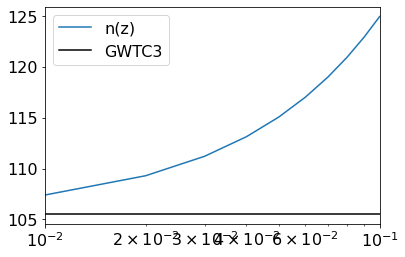

In [76]:
def norm_merger_rate_density(z):
    merger_rate_density = injections.bns_md_merger_rate(z)
    normalised_merger_rate_density = merger_rate_density * GWTC3_MERGER_RATE_DENSITY_BNS / injections.bns_md_merger_rate(0)
    return normalised_merger_rate_density

merger_rate_density = np.array(list(map(norm_merger_rate_density, z_list)))
differential_comoving_volume_list_Gpc = np.array(list(map(lambda z: differential_comoving_volume(z)*1e-9, z_list)))

plt.plot(z_list, merger_rate_density, label='n(z)')
plt.axhline(GWTC3_MERGER_RATE_DENSITY_BNS, color='k', label='GWTC3')
plt.xlim(zmin, zmax)
plt.legend()
plt.xscale('log')

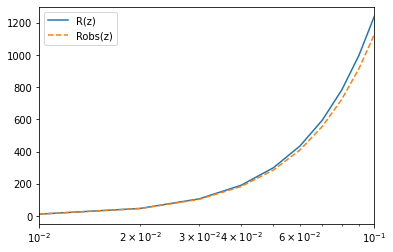

In [54]:
merger_rate_list = np.array(list(map(merger_rate_bns, z_list)))

Robs = lambda z: merger_rate_in_obs_frame(merger_rate_bns, z)
Robs_list = np.array(list(map(Robs, z_list)))

plt.plot(z_list, merger_rate_list, label='R(z)')
plt.plot(z_list, Robs_list, label='Robs(z)', linestyle='--')
plt.xlim(zmin, zmax)
plt.xscale('log')
plt.legend()


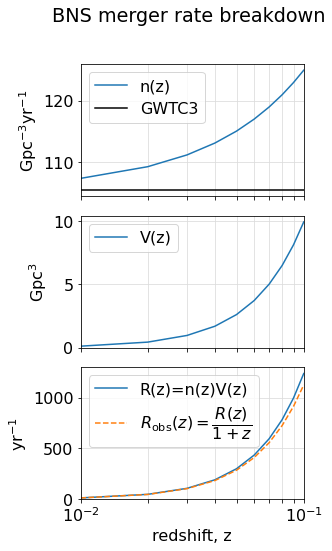

In [82]:
plt.rcParams.update({"font.size": 16})
fig, (ax1, ax15, ax2) = plt.subplots(
    3, 1, sharex=True, figsize=(4, 8), gridspec_kw=dict(hspace=0.15)
)

ax1.plot(z_list, merger_rate_density, label='n(z)')
ax1.axhline(GWTC3_MERGER_RATE_DENSITY_BNS, color='k', label='GWTC3')
ax1.legend()
ax1.grid("both", "both", color="gainsboro")
ax1.set(ylabel=r'Gpc${}^{-3}$yr${}^{-1}$')

ax15.plot(z_list, differential_comoving_volume_list_Gpc, label='V(z)')
ax15.set(ylabel=r'Gpc${}^3$', ylim=(0, None))
ax15.legend()
ax15.grid("both", "both", color="gainsboro")

ax2.plot(z_list, merger_rate_list, label='R(z)=n(z)V(z)')
ax2.plot(z_list, Robs_list, label=r'$R_\mathrm{obs}(z)=\dfrac{R(z)}{1+z}$', linestyle='--')
ax2.set_xlim(zmin, zmax)
ax2.set_xscale('log')
ax2.legend()
ax2.grid("both", "both", color="gainsboro")
ax2.set(xlabel='redshift, z', ylabel=r'yr${}^{-1}$', ylim=(0, None))
ax2.set_xticks(z_list, labels=[r'$10^{-2}$', *['' for _ in z_list[1:-1]], r'$10^{-1}$'])

fig.suptitle('BNS merger rate breakdown')

fig.savefig(f"./plots/BNS_merger_rate_breakdown_for_Paul.pdf", bbox_inches="tight")
plt.show()

Ethan's suggestion for hat graph alternative

In [33]:
import matplotlib.pyplot as plt 
from useful_plotting_functions import BANG_WONG_COLOURS

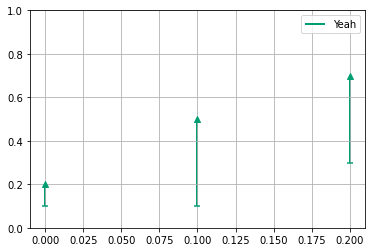

In [44]:
data = [(0, 0.1, 0.2), (0.1, 0.1, 0.5), (0.2, 0.3, 0.7),]
labels = range(3)

# for i, datum in enumerate(data):
#     x, y0, y1 = datum
#     colour = list(BANG_WONG_COLOURS.values())[i]
#     plt.vlines(x, y0, y1, color=colour, zorder=1, linewidth=2, label=labels[i])
#     plt.scatter(x, y0, marker='_', color=colour, zorder=2)
#     # plt.scatter(x, (y0+y1)/2, marker='^', color=colour, zorder=2) #, s=50)
#     plt.scatter(x, y1, marker='^', color=colour, zorder=2)

# list form
x = [v[0] for v in data]
y0 = [v[1] for v in data]
y1 = [v[2] for v in data]
colour = BANG_WONG_COLOURS['Bluish green']
label = 'Yeah'

plt.vlines(x, y0, y1, color=colour, zorder=1, linewidth=2, label=label)
plt.scatter(x, y0, marker='_', color=colour, zorder=2)
plt.scatter(x, y1, marker='^', color=colour, zorder=2)

plt.ylim(0, 1)

plt.grid()
plt.legend()

plt.show()